In [ ]:
#DCGAN
#Deep Convolutional Generative Adversarial Networks
#Using DCGAN to generate food images by learning from the Kaggle Food-101 datasets

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, ReLU, LeakyReLU, Reshape, Flatten, UpSampling2D, AveragePooling2D
from tensorflow.keras.initializers import RandomNormal, RandomUniform
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
import h5py

# dataset filename
filename = "food_c101_n10099_r64x64x3.h5"

food_dataset = h5py.File(filename, 'r')

print(food_dataset.keys())

category = np.array(food_dataset['category'])
category_names = np.array(food_dataset['category_names'])
orig_data = np.array(food_dataset['images'])

# check shape
orig_data.shape

<KeysViewHDF5 ['category', 'category_names', 'images']>


(10099, 64, 64, 3)

In [4]:
# Normalize pixels : -1 to 1
m = orig_data.shape[0]
h = orig_data.shape[1]
w = orig_data.shape[2]

# normalize pixel values from [0, 255] to [-1, 1]
data = (orig_data / 127.5) - 1
print("image normalized")
print("pixal min value = {}".format(data.min()))
print("pixal max value = {}".format(data.max()))

image normalized
pixal min value = -1.0
pixal max value = 1.0


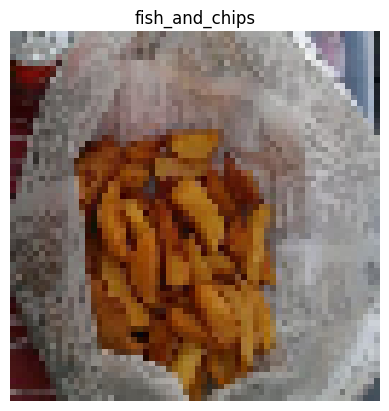

In [5]:
x = 11
one_item = category_names[category[x]][0].decode('utf-8')
plt.figure()
plt.imshow(orig_data[x])
plt.title(one_item)
plt.axis('off')
plt.show()

In [6]:
# We smooth the true labels from 1 to a float value between [0.7, 1.3], and false labels from 0 to a float value between [0, 0.3]

def smoothing_true_labels(labels):
    """
    Add some noise to label = 1 to make it in the range [0.7, 1.3]
    """

    return 1 + np.random.uniform(low = -0.3, high = 0.3, size = labels.shape)


def smoothing_fake_labels(labels):
    """
    Add some noise to label = 0 to make it in the range [0.0, 0.3]
    """

    return np.random.uniform(low = 0.0, high = 0.3, size = labels.shape)

In [7]:
# The generator is built by deep transposed convolutional layers
def build_generator_DC(hidden_dim = 100):

    ## weight initialization
    w_init = RandomNormal(mean=0.0, stddev=0.02)

    ## input vector
    z = Input(shape = (hidden_dim, )) # (None, hidden_dim)

    ## Project and reshape
    x = Dense(4*4*1024)(z)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Reshape((4, 4, 1024))(x)

    ## Conv2D-T
    x = Conv2DTranspose(512, 3, 2, padding = 'same', kernel_initializer = w_init, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    ## Conv2D-T
    x = Conv2DTranspose(256, 3, 2, padding = 'same', kernel_initializer = w_init, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    ## Conv2D-T
    x = Conv2DTranspose(128, 3, 2, 'same', kernel_initializer = w_init, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    ## last Conv2DT (no batch norm!)
    img = Conv2DTranspose(3, 3, 2, 'same', activation = 'tanh', kernel_initializer = w_init, use_bias = False)(x)

    # generator model
    model = Model(inputs = z, outputs = img, name = 'generator')

    return model

## Show the model paramenters and delete the model
generator = build_generator_DC()
generator.summary()
del generator

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         4718592   
 anspose)                                                

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [8]:
def build_discriminator_DC():

    ## weight initialization
    w_init = RandomNormal(mean=0.0, stddev=0.02)

    ## input image (img)
    img = Input(shape = (64, 64, 3))

    ## Conv
    x = Conv2D(128, 3, 2, 'same', kernel_initializer = w_init)(img)
    #x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #x = Dropout(0.2)(x)

    ## Conv
    x = Conv2D(256, 3, 2, 'same', kernel_initializer = w_init)(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #x = Dropout(0.2)(x)

    ## Conv
    x = Conv2D(512, 3, 2, 'same', kernel_initializer = w_init)(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #x = Dropout(0.2)(x)

    ## Conv
    x = Conv2D(1024, 3, 2, 'same', kernel_initializer = w_init)(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #x = Dropout(0.2)(x)

    ## final layer
    x = Flatten()(x)
    #x = Dropout(0.2)(x)
    y = Dense(1, activation = 'sigmoid')(x)

    # generator model
    model = Model(inputs = img, outputs = y, name = 'discriminator')

    return model

## Show the model paramenters and delete the model
discriminator = build_discriminator_DC()
discriminator.summary()
del discriminator

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1180160   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 512)       

In [10]:
#We connect the generator and the discriminator. At this stage we only want to train the generator, by setting discriminator.trainable = False
def build_DCGAN(hidden_dim, G, D):

    D.trainable = False

    z = Input(shape = (hidden_dim, ))

    y = D(G(z))

    DCGAN = Model(inputs = z, outputs = y)

    return DCGAN

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_8 (Dense)             (None, 16384)             32768     
                                                                 
 batch_normalization_16 (Ba  (None, 16384)             65536     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_16 (Conv2  (None, 8, 8, 512)         4718592   
 DTranspose)                                             

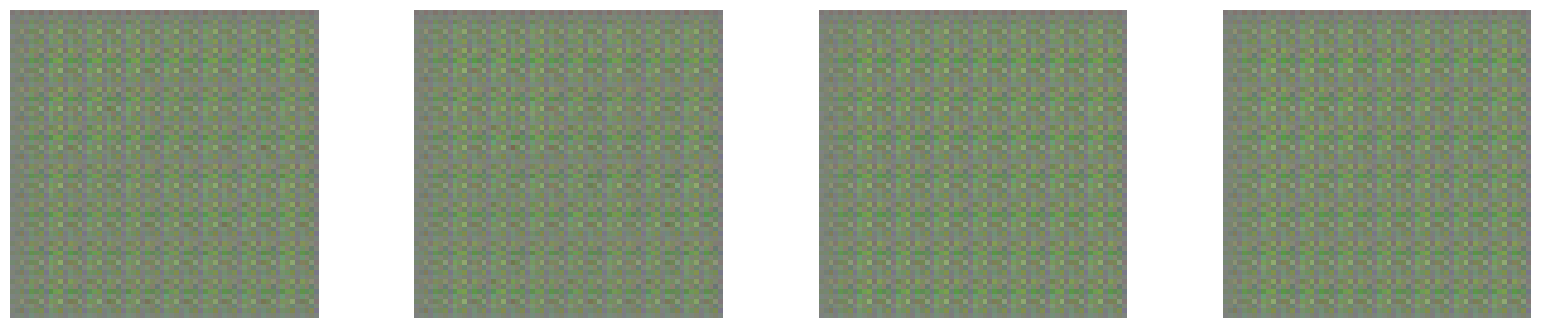

1/1 [==============================] - 0s 19ms/step
Epoch 1 	 g_loss: 86.9386, d_loss:154.0813, d_acc: 0.0000


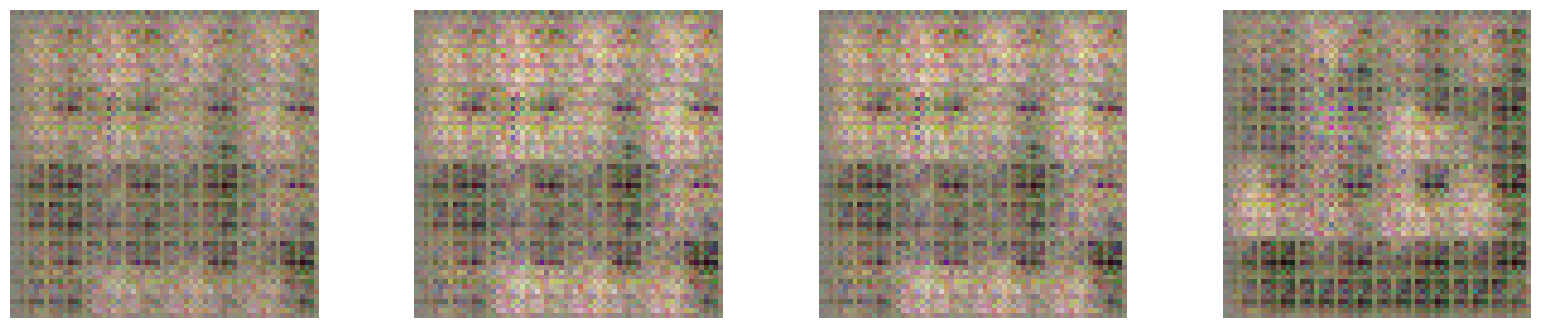

1/1 [==============================] - 0s 17ms/step
Epoch 2 	 g_loss: 377.9936, d_loss:192.3363, d_acc: 0.0000


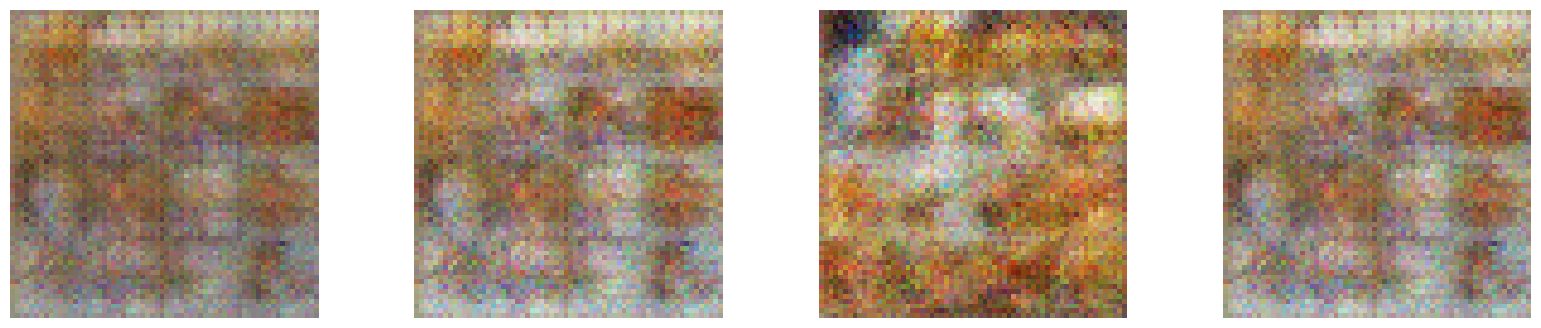

1/1 [==============================] - 0s 17ms/step
Epoch 3 	 g_loss: 459.5637, d_loss:211.2289, d_acc: 0.0000


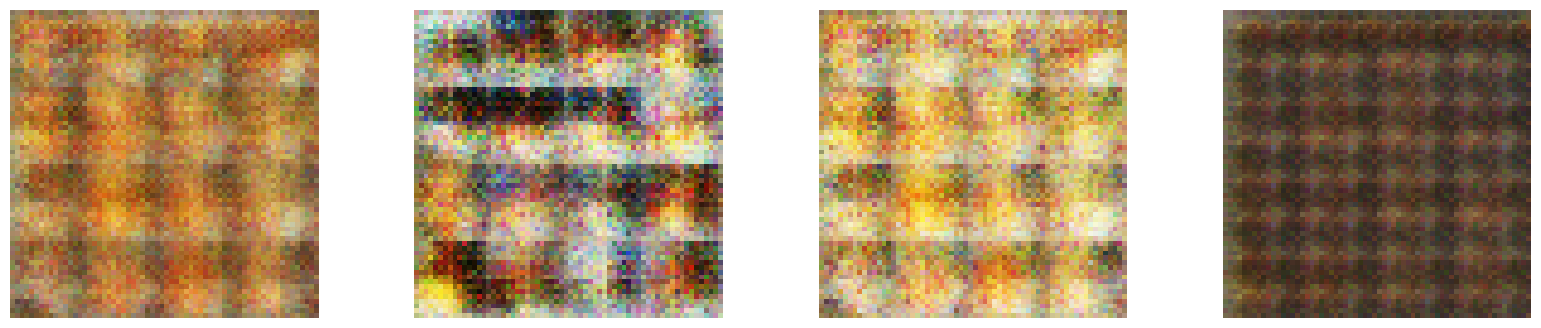

1/1 [==============================] - 0s 17ms/step
Epoch 4 	 g_loss: 508.6188, d_loss:200.0756, d_acc: 0.0000


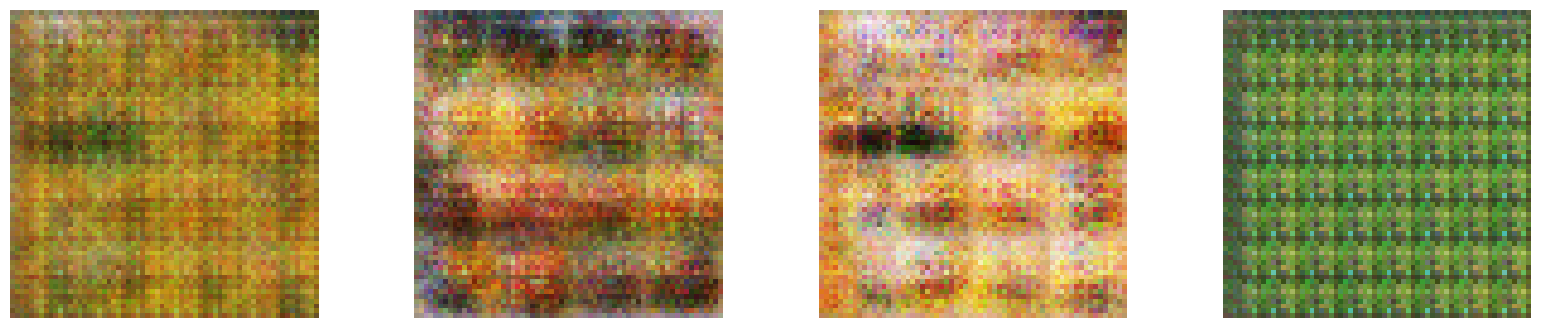

1/1 [==============================] - 0s 19ms/step
Epoch 5 	 g_loss: 455.7612, d_loss:179.0848, d_acc: 0.0000


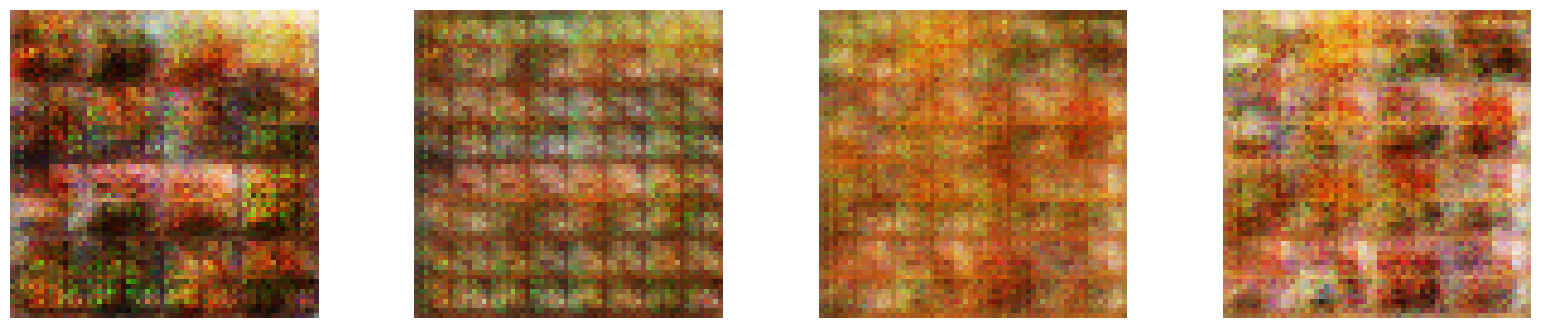

1/1 [==============================] - 0s 25ms/step
Epoch 6 	 g_loss: 507.4228, d_loss:173.2710, d_acc: 0.0000


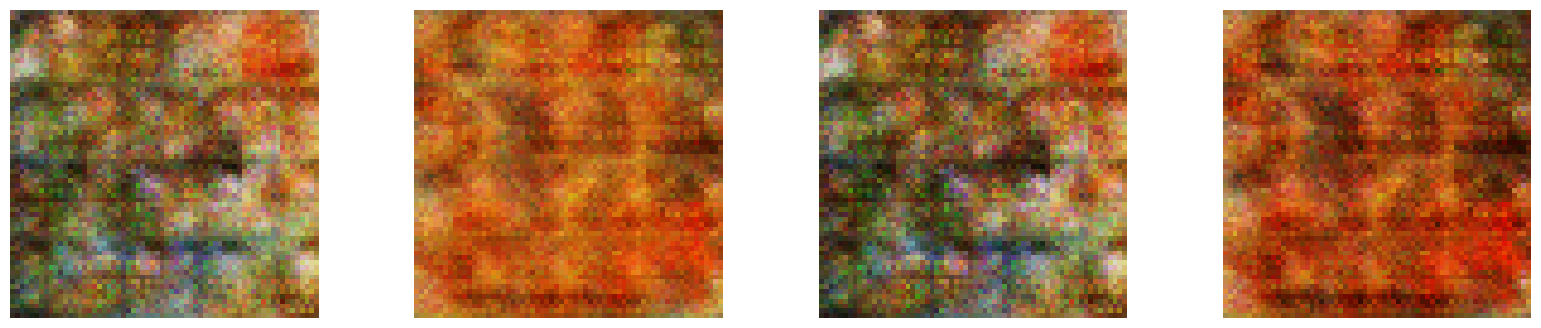

1/1 [==============================] - 0s 18ms/step
Epoch 7 	 g_loss: 535.5970, d_loss:169.3717, d_acc: 0.0000


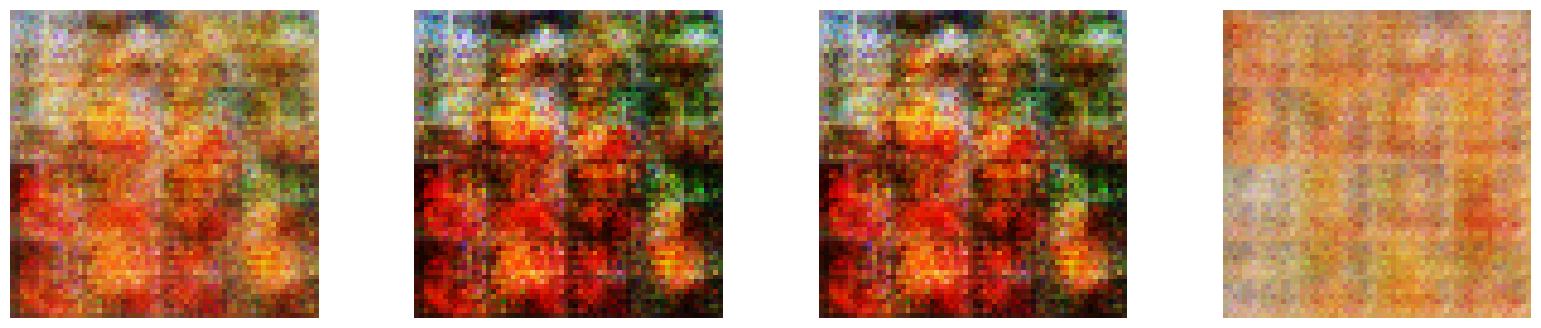

1/1 [==============================] - 0s 22ms/step
Epoch 8 	 g_loss: 567.8515, d_loss:177.7190, d_acc: 0.0000


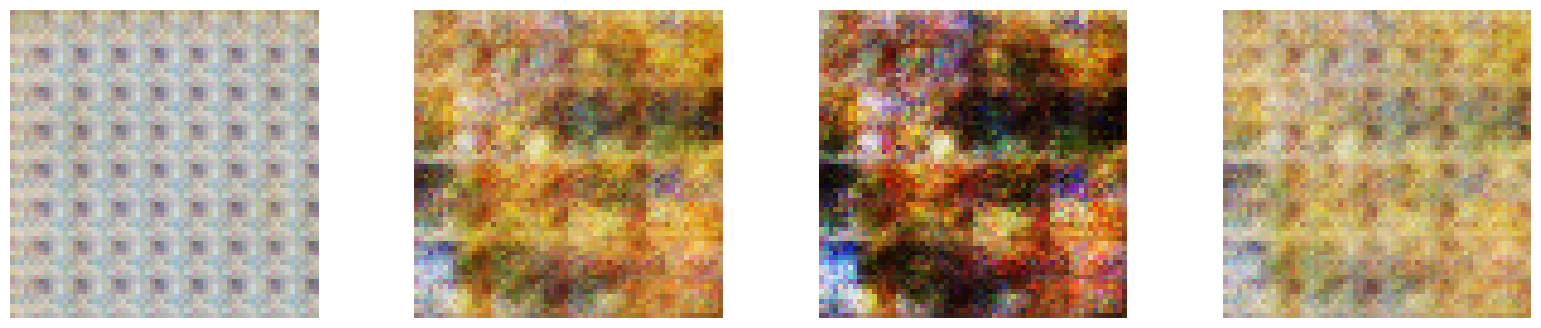

1/1 [==============================] - 0s 19ms/step
Epoch 9 	 g_loss: 536.3782, d_loss:170.3456, d_acc: 0.0000


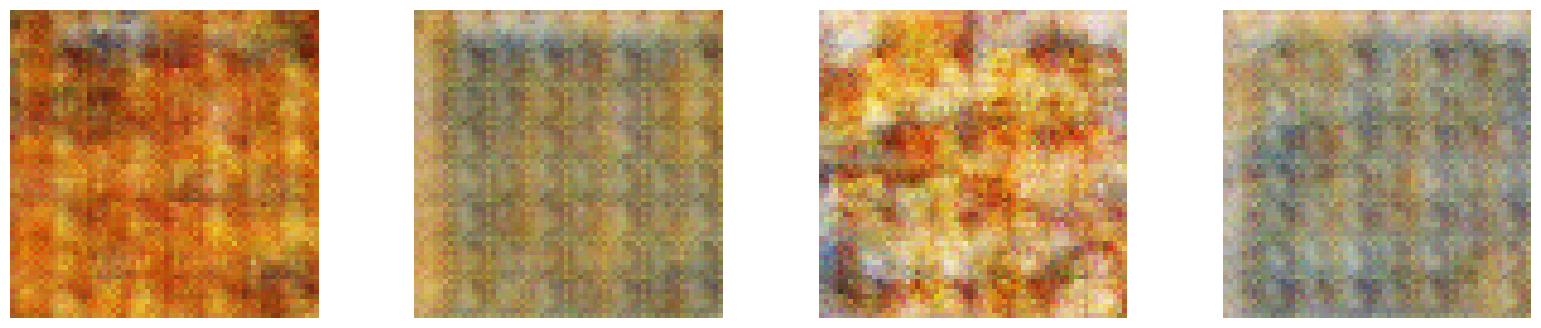

1/1 [==============================] - 0s 19ms/step
Epoch 10 	 g_loss: 535.3169, d_loss:171.5866, d_acc: 0.0000


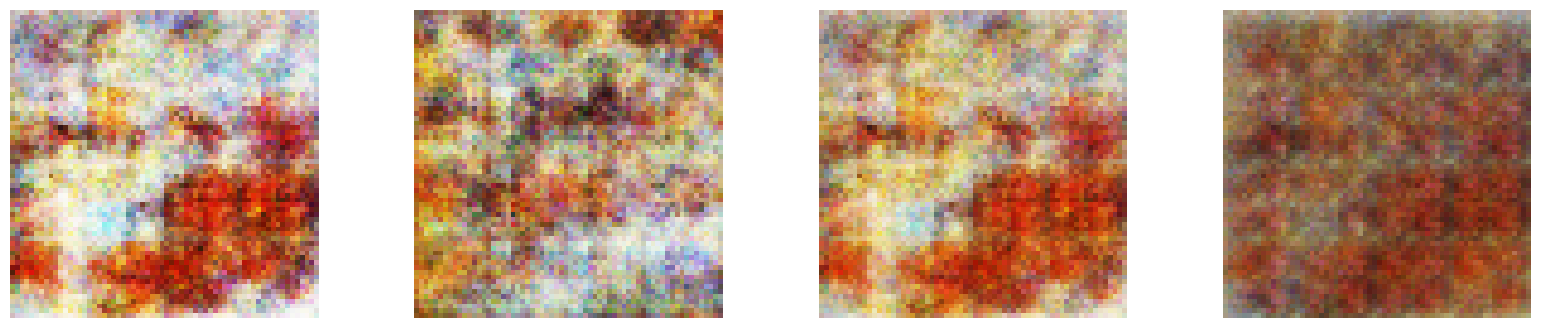

1/1 [==============================] - 0s 18ms/step
Epoch 11 	 g_loss: 568.8021, d_loss:173.0287, d_acc: 0.0000


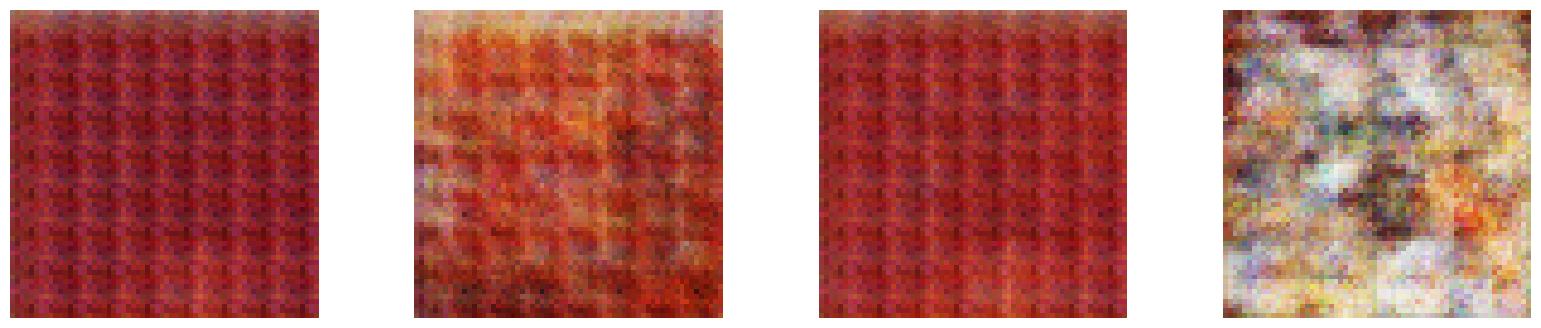

1/1 [==============================] - 0s 18ms/step
Epoch 12 	 g_loss: 609.2250, d_loss:165.2946, d_acc: 0.0000


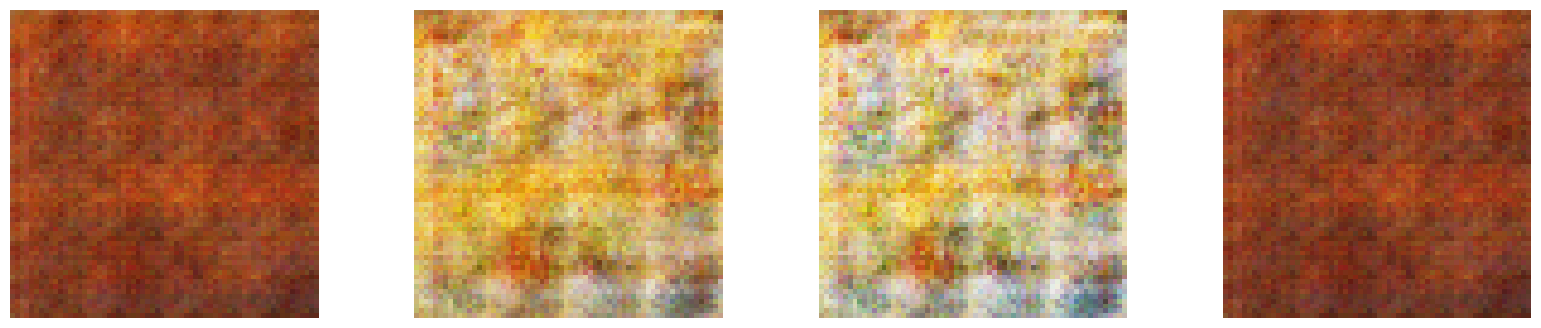

1/1 [==============================] - 0s 17ms/step
Epoch 13 	 g_loss: 466.0634, d_loss:174.3725, d_acc: 0.0000


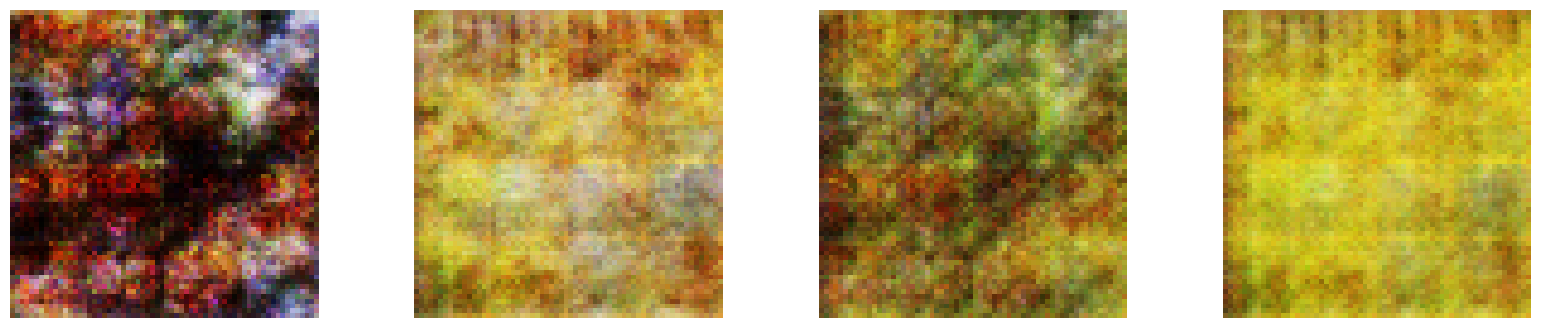

1/1 [==============================] - 0s 20ms/step
Epoch 14 	 g_loss: 522.7243, d_loss:167.5461, d_acc: 0.0000


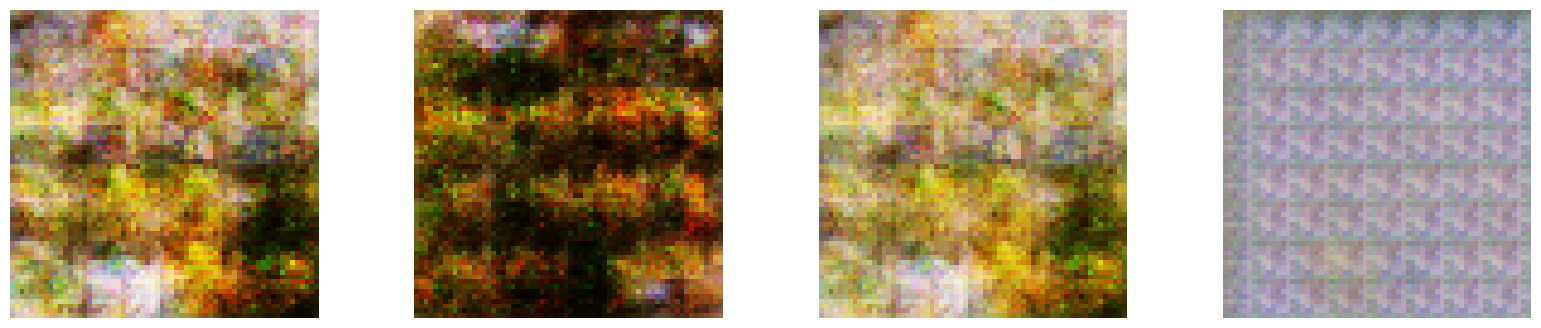

1/1 [==============================] - 0s 17ms/step
Epoch 15 	 g_loss: 453.9336, d_loss:168.2891, d_acc: 0.0000


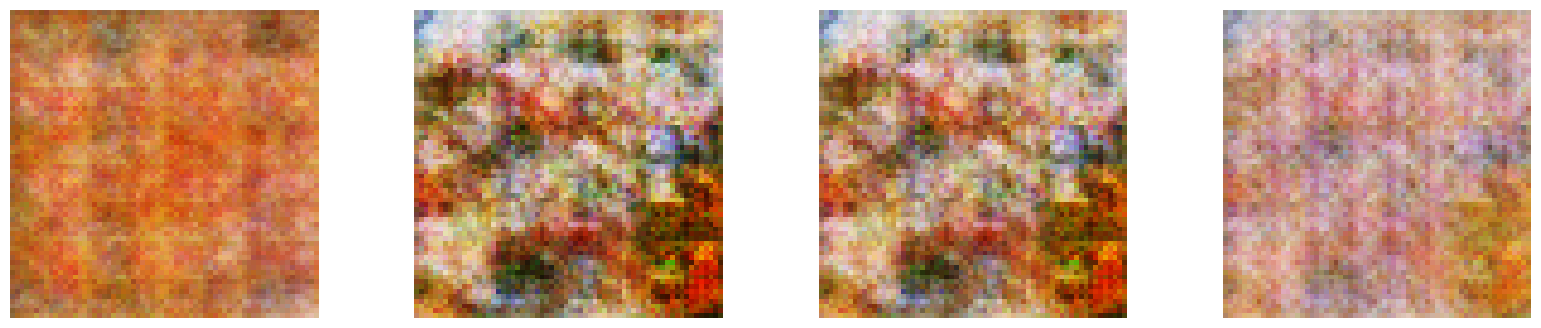

1/1 [==============================] - 0s 18ms/step
Epoch 16 	 g_loss: 607.3847, d_loss:179.1930, d_acc: 0.0000


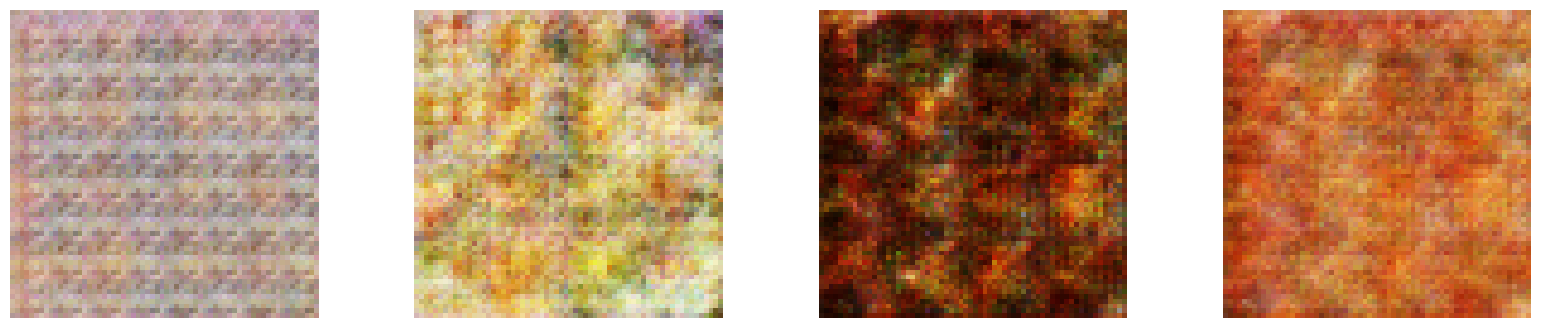

1/1 [==============================] - 0s 19ms/step
Epoch 17 	 g_loss: 536.1045, d_loss:171.6996, d_acc: 0.0000


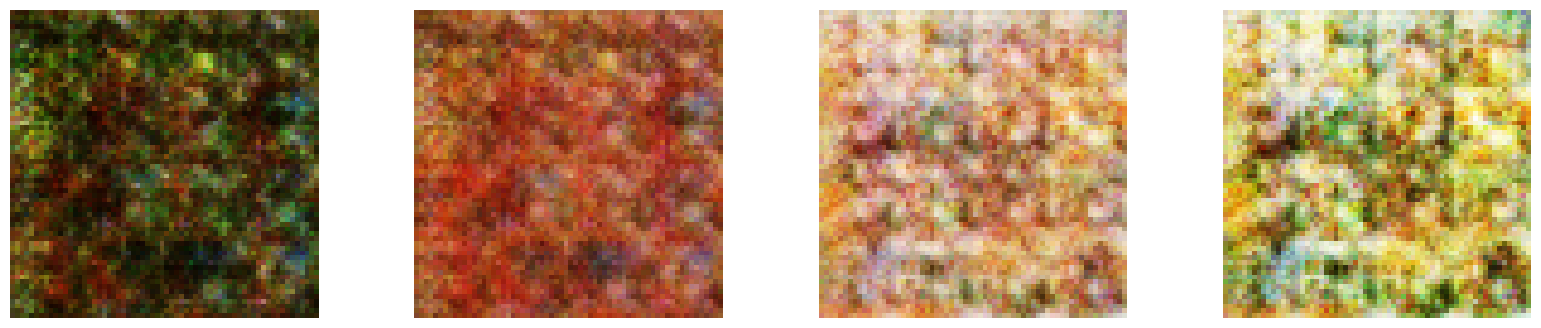

1/1 [==============================] - 0s 18ms/step
Epoch 18 	 g_loss: 528.5703, d_loss:167.2862, d_acc: 0.0000


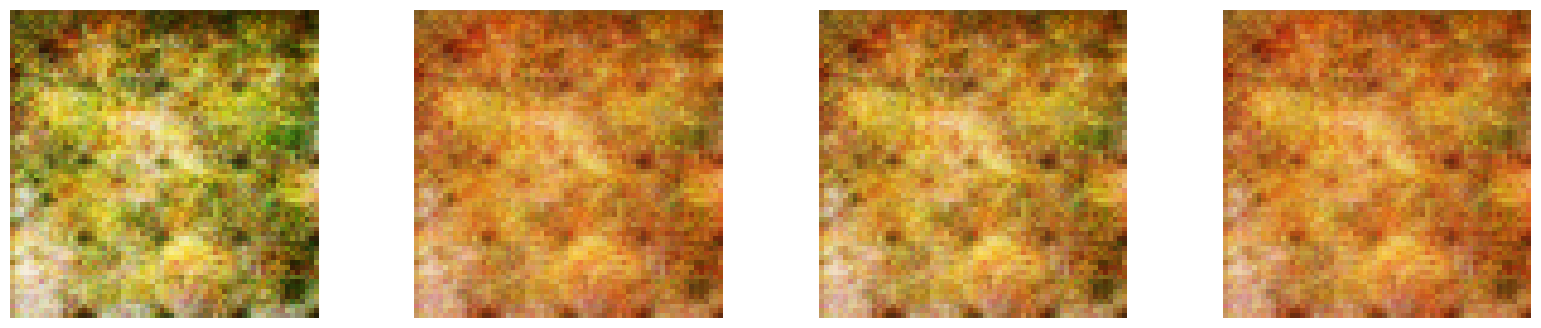

1/1 [==============================] - 0s 17ms/step
Epoch 19 	 g_loss: 497.8960, d_loss:179.2095, d_acc: 0.0000


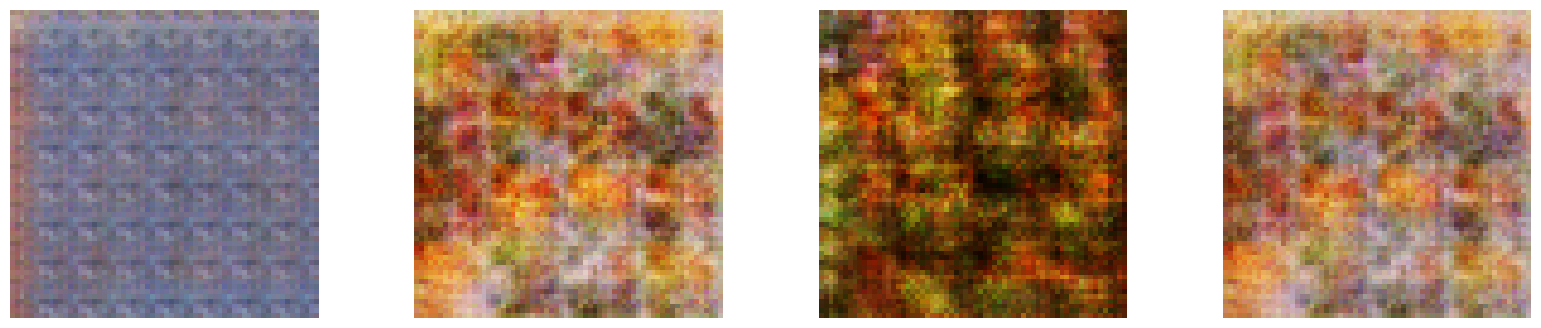

1/1 [==============================] - 0s 26ms/step
Epoch 20 	 g_loss: 498.1201, d_loss:173.7262, d_acc: 0.0000


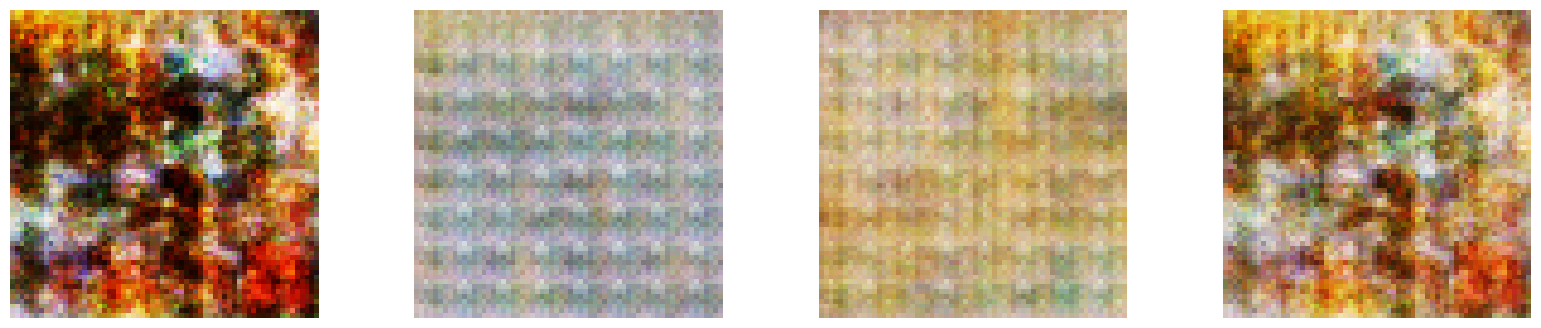

1/1 [==============================] - 0s 18ms/step
Epoch 21 	 g_loss: 525.3592, d_loss:187.7900, d_acc: 0.0000


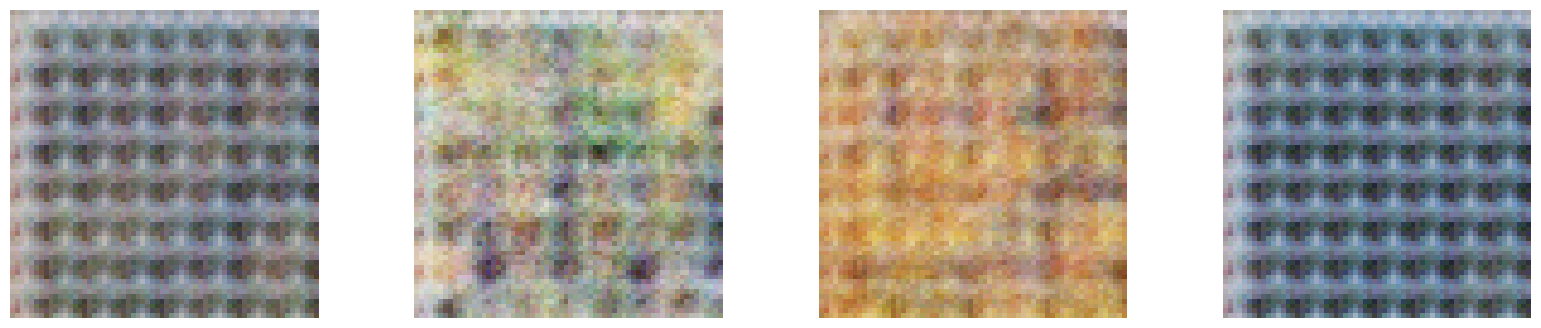

1/1 [==============================] - 0s 20ms/step
Epoch 22 	 g_loss: 472.7278, d_loss:168.2961, d_acc: 0.0000


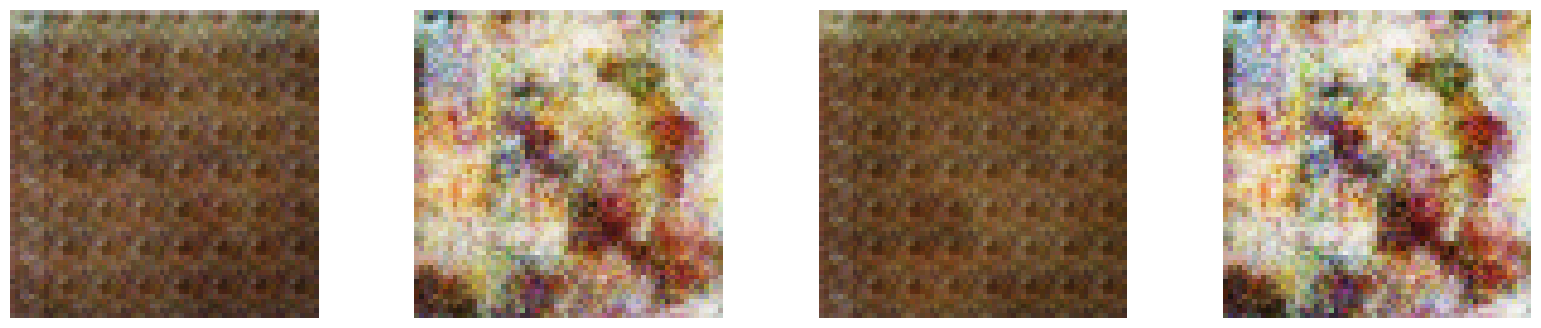

1/1 [==============================] - 0s 21ms/step
Epoch 23 	 g_loss: 526.9473, d_loss:170.6491, d_acc: 0.0000


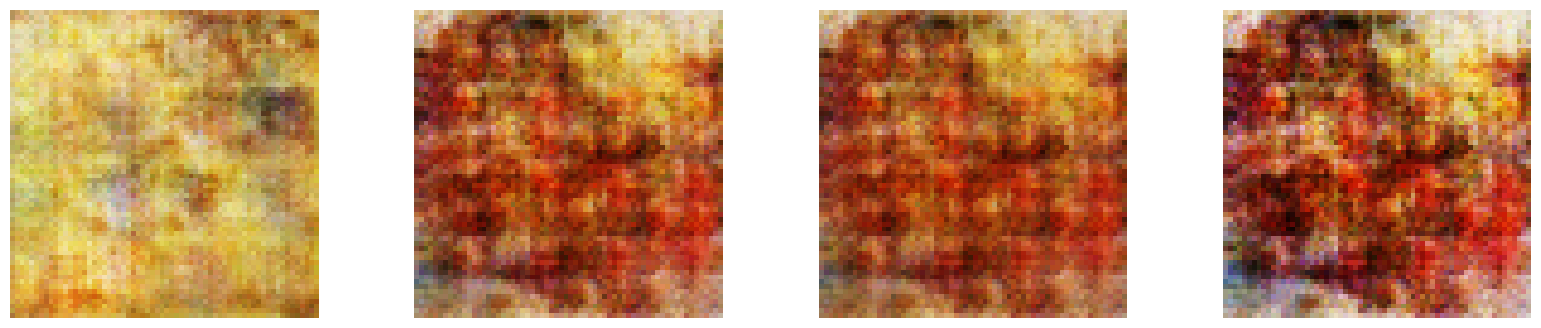

1/1 [==============================] - 0s 18ms/step
Epoch 24 	 g_loss: 552.6808, d_loss:175.8696, d_acc: 0.0000


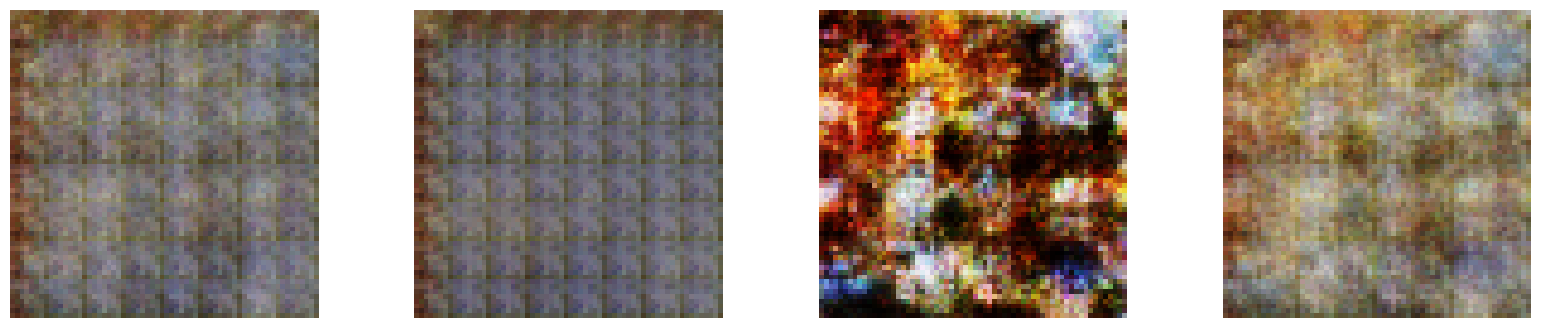

1/1 [==============================] - 0s 17ms/step
Epoch 25 	 g_loss: 394.1948, d_loss:169.1389, d_acc: 0.0000


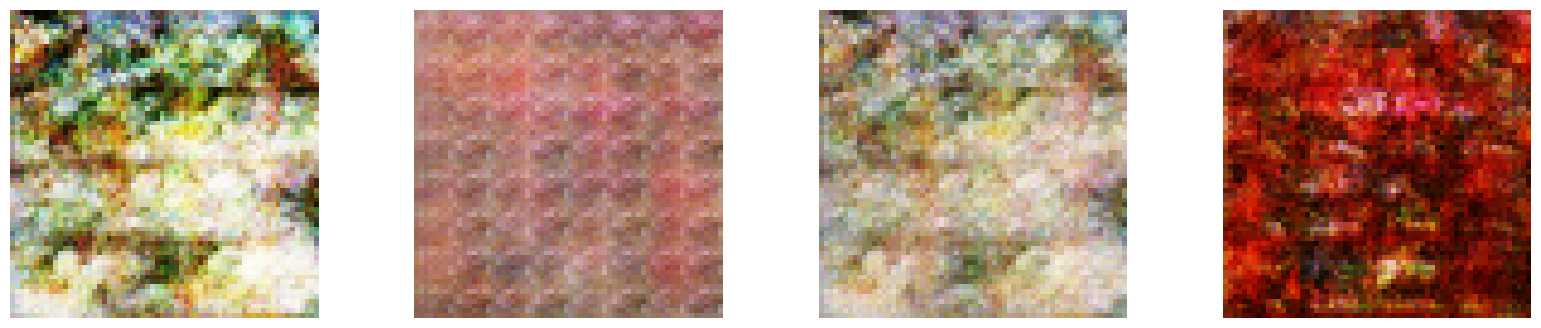

1/1 [==============================] - 0s 22ms/step
Epoch 26 	 g_loss: 473.7363, d_loss:170.7112, d_acc: 0.0000


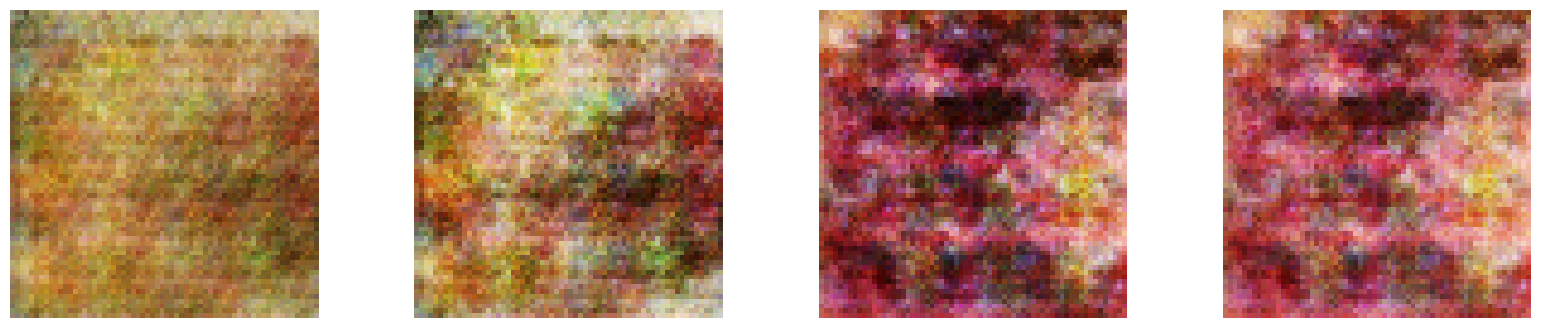

1/1 [==============================] - 0s 18ms/step
Epoch 27 	 g_loss: 521.5372, d_loss:177.7359, d_acc: 0.0000


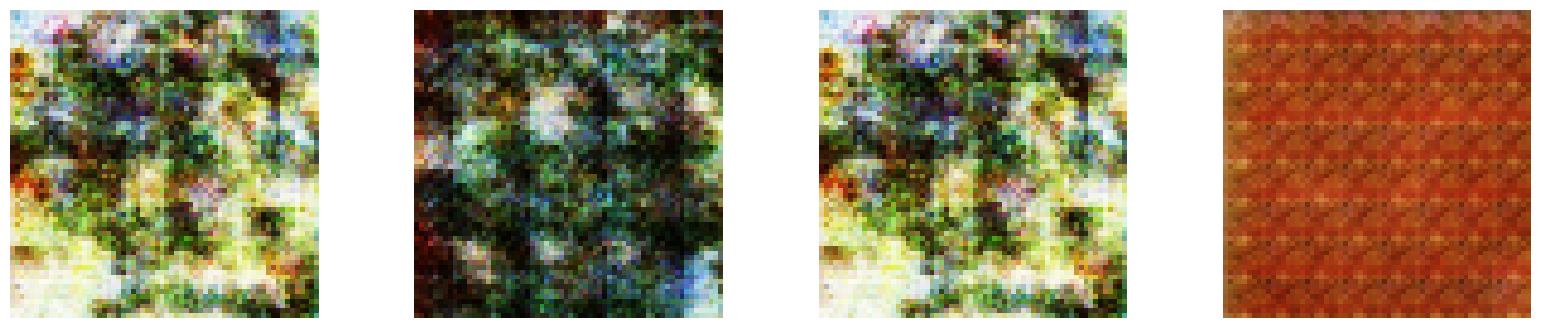

1/1 [==============================] - 0s 17ms/step
Epoch 28 	 g_loss: 574.6635, d_loss:171.7596, d_acc: 0.0000


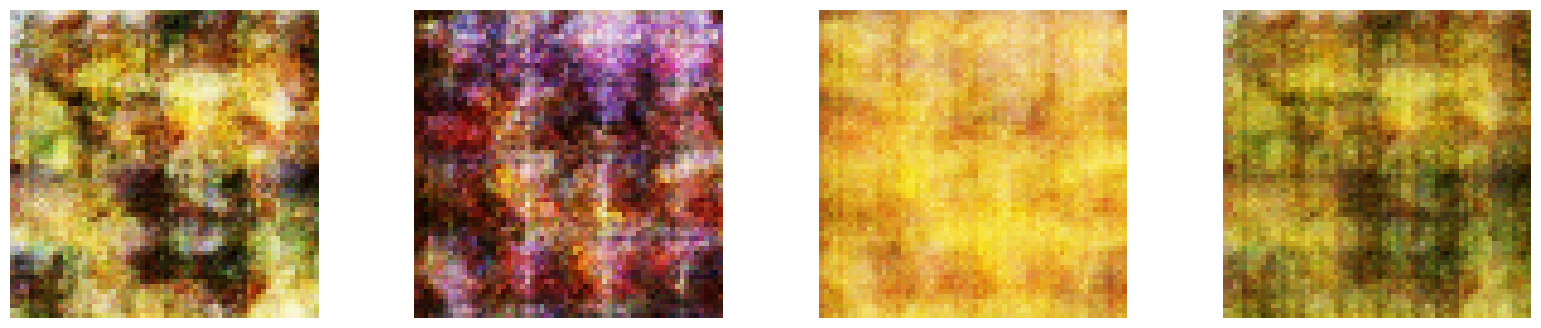

1/1 [==============================] - 0s 21ms/step
Epoch 29 	 g_loss: 566.9512, d_loss:179.9803, d_acc: 0.0000


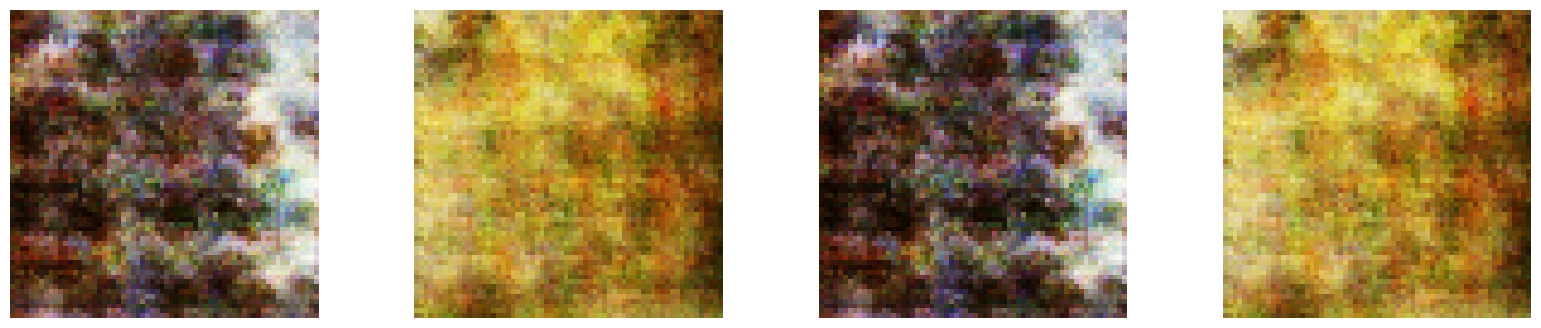

1/1 [==============================] - 0s 18ms/step
Epoch 30 	 g_loss: 568.4679, d_loss:174.0069, d_acc: 0.0000


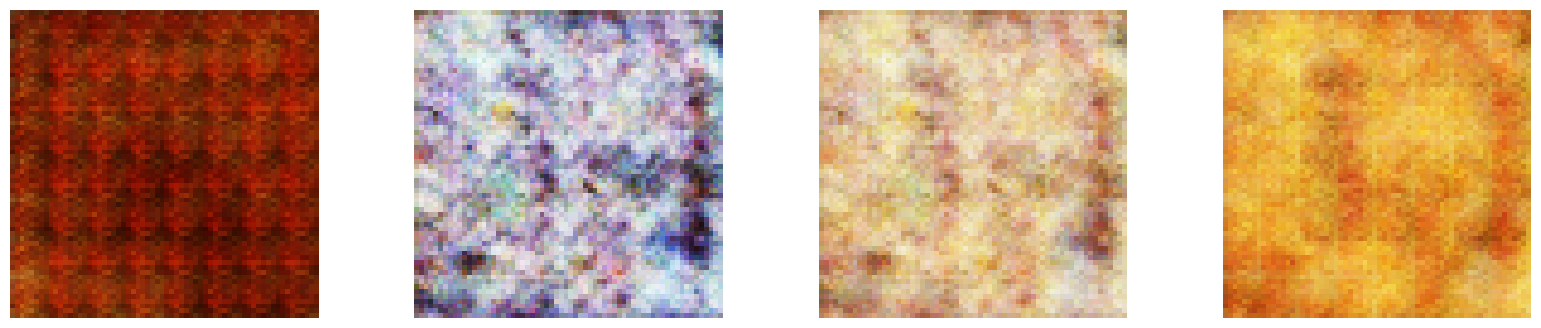

1/1 [==============================] - 0s 17ms/step
Epoch 31 	 g_loss: 555.1642, d_loss:182.6605, d_acc: 0.0000


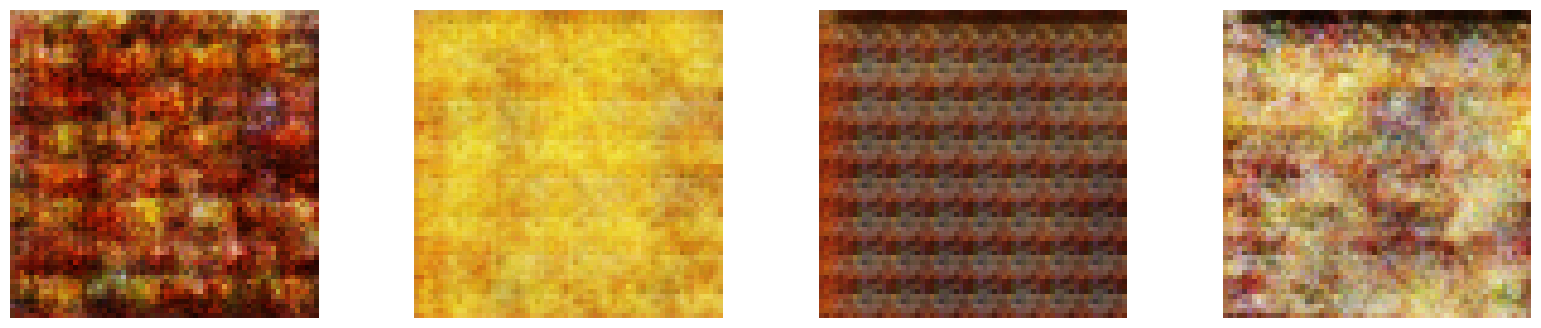

1/1 [==============================] - 0s 20ms/step
Epoch 32 	 g_loss: 490.1289, d_loss:174.9648, d_acc: 0.0000


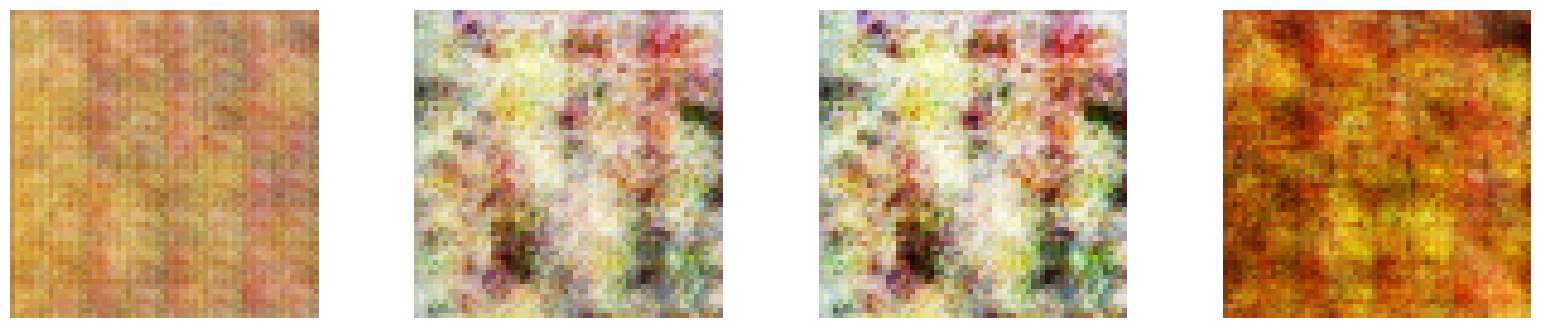

1/1 [==============================] - 0s 18ms/step
Epoch 33 	 g_loss: 429.8469, d_loss:177.5296, d_acc: 0.0000


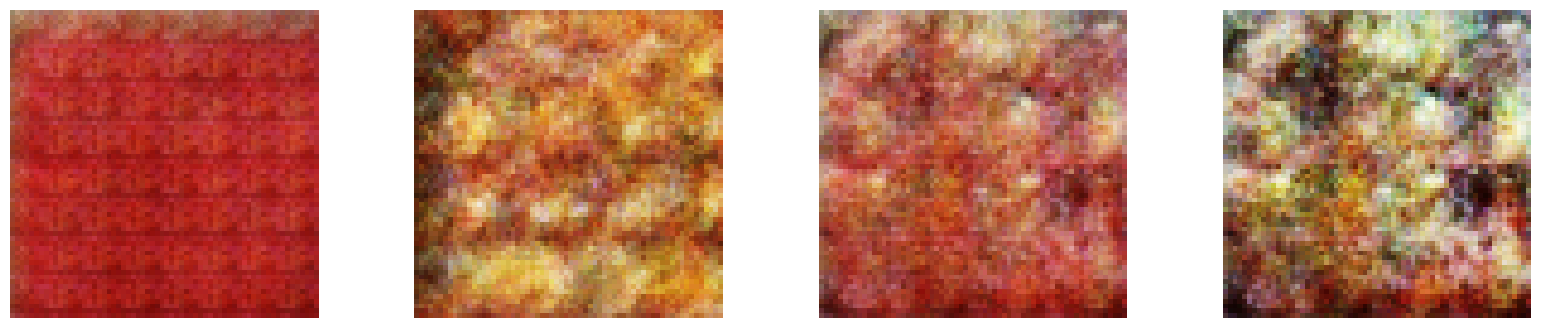

1/1 [==============================] - 0s 17ms/step
Epoch 34 	 g_loss: 594.2316, d_loss:178.5278, d_acc: 0.0000


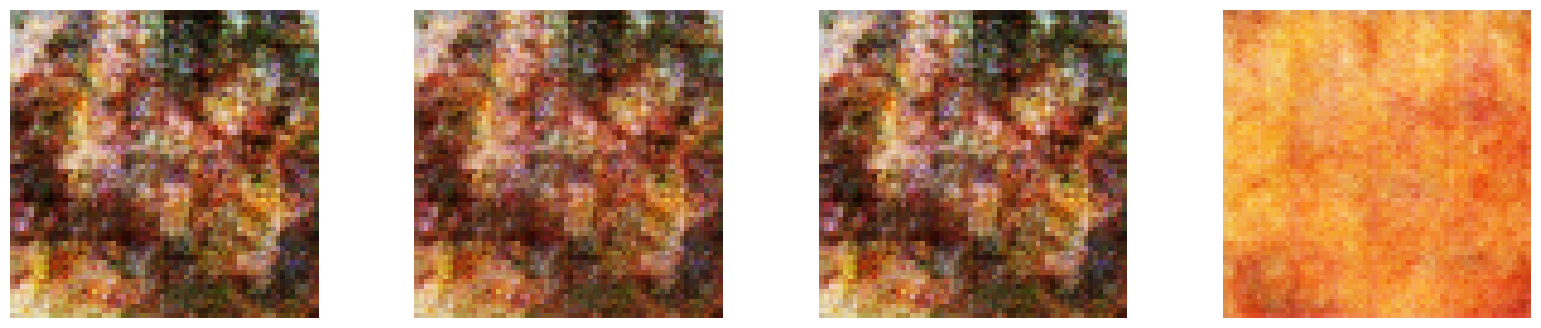

1/1 [==============================] - 0s 23ms/step
Epoch 35 	 g_loss: 517.1764, d_loss:175.5519, d_acc: 0.0000


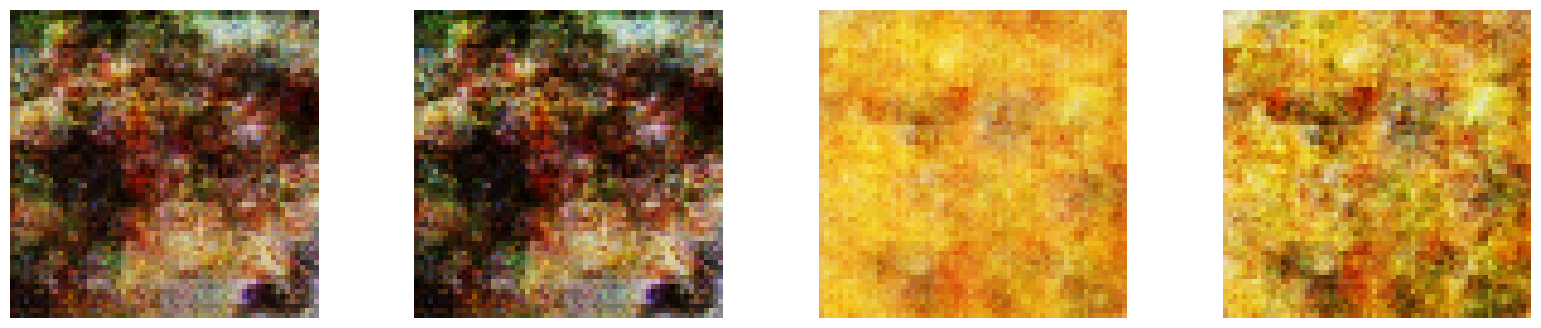

1/1 [==============================] - 0s 29ms/step
Epoch 36 	 g_loss: 454.9467, d_loss:169.9870, d_acc: 0.0000


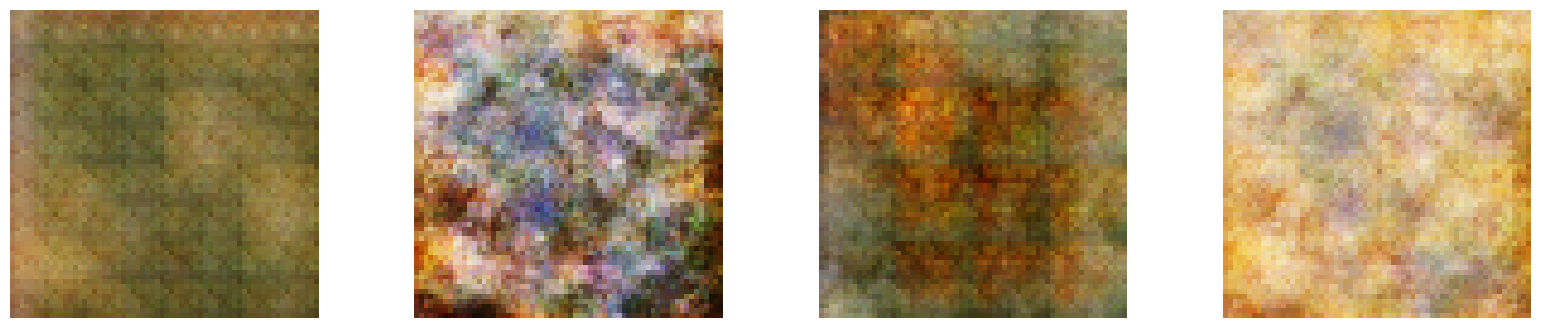

1/1 [==============================] - 0s 20ms/step
Epoch 37 	 g_loss: 465.0965, d_loss:165.7597, d_acc: 0.0000


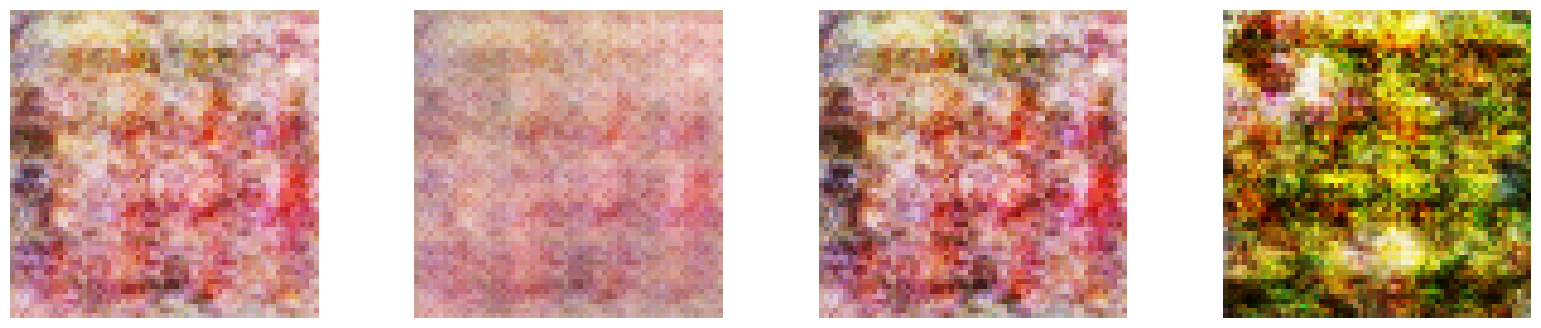

1/1 [==============================] - 0s 24ms/step
Epoch 38 	 g_loss: 451.9446, d_loss:171.0625, d_acc: 0.0000


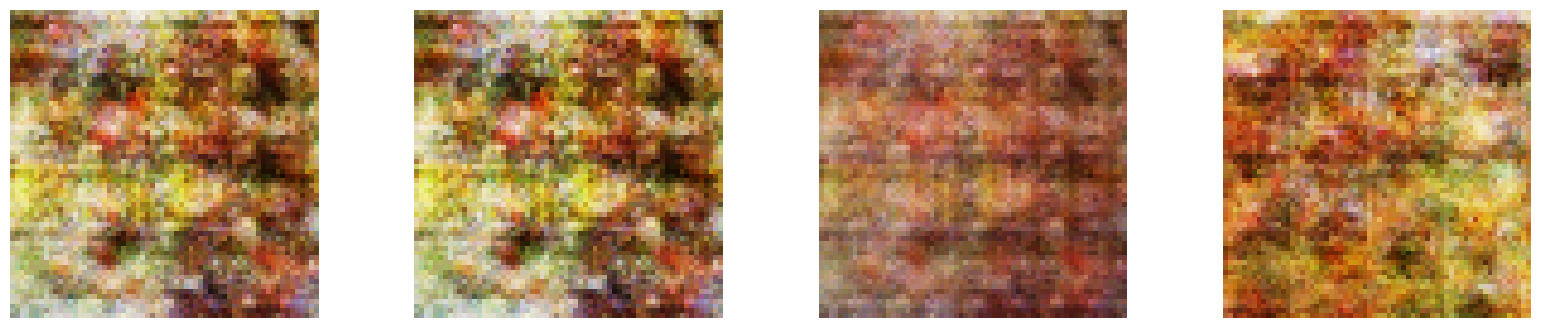

1/1 [==============================] - 0s 19ms/step
Epoch 39 	 g_loss: 465.2103, d_loss:188.9247, d_acc: 0.0000


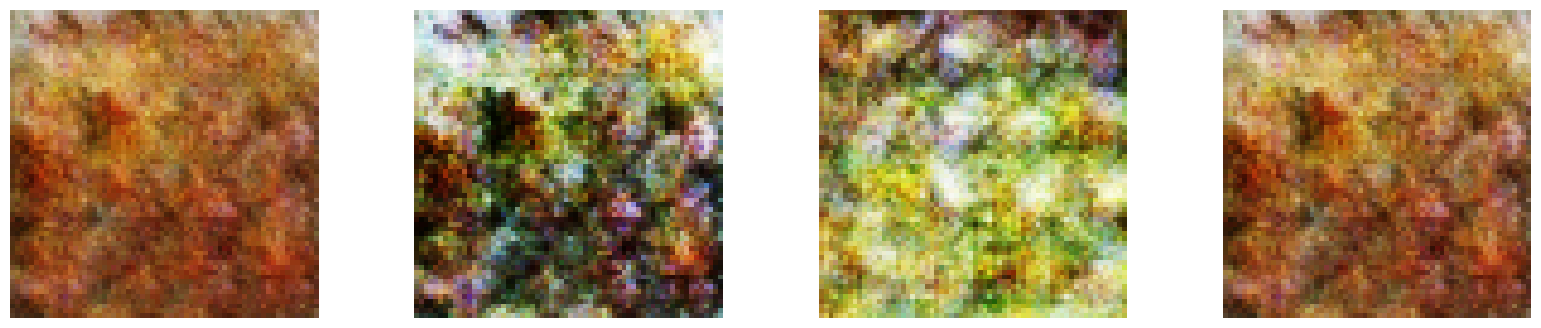

1/1 [==============================] - 0s 18ms/step
Epoch 40 	 g_loss: 614.5046, d_loss:178.4671, d_acc: 0.0000


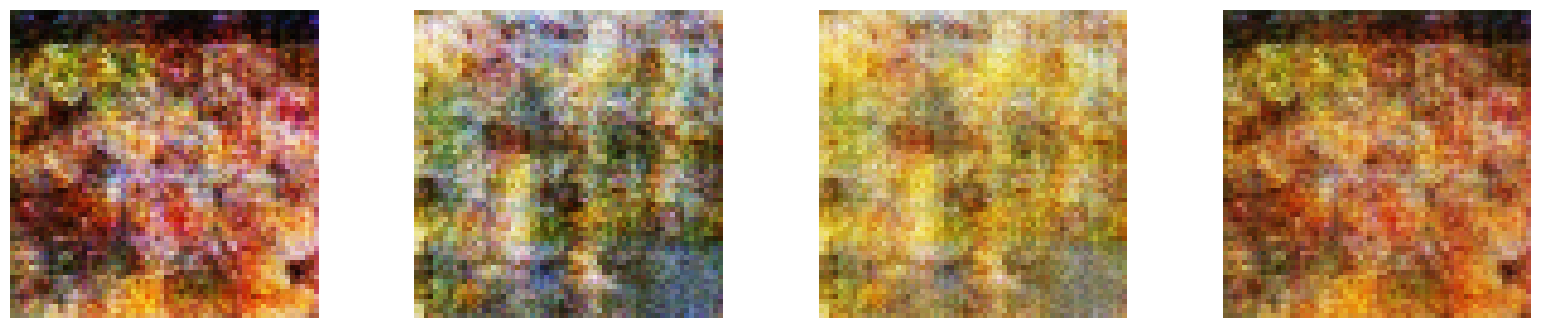

1/1 [==============================] - 0s 22ms/step
Epoch 41 	 g_loss: 512.0520, d_loss:180.5300, d_acc: 0.0000


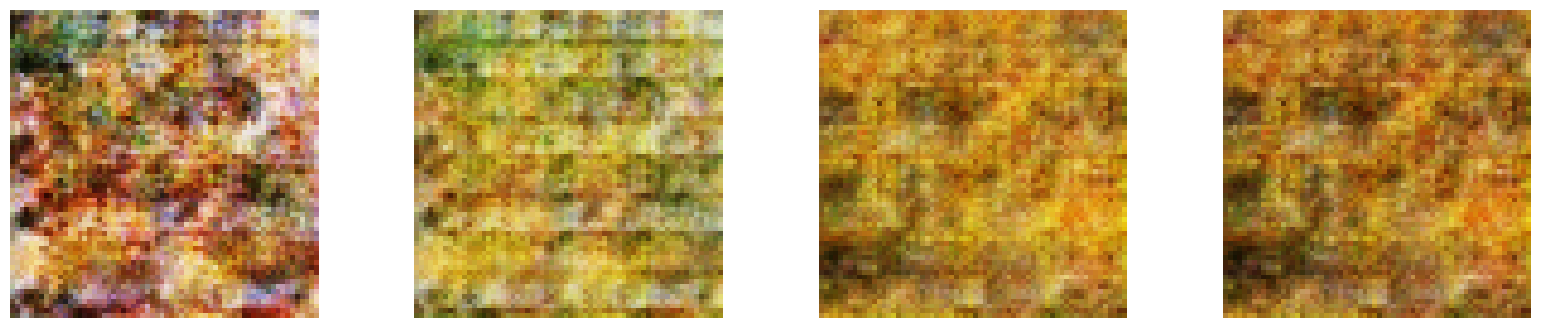

1/1 [==============================] - 0s 20ms/step
Epoch 42 	 g_loss: 575.1226, d_loss:174.2262, d_acc: 0.0000


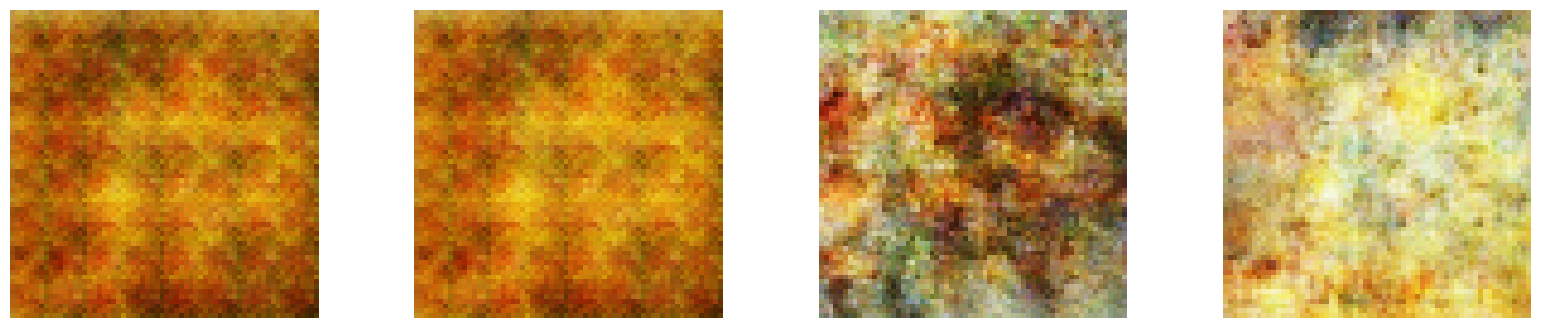

1/1 [==============================] - 0s 19ms/step
Epoch 43 	 g_loss: 507.3483, d_loss:175.3228, d_acc: 0.0000


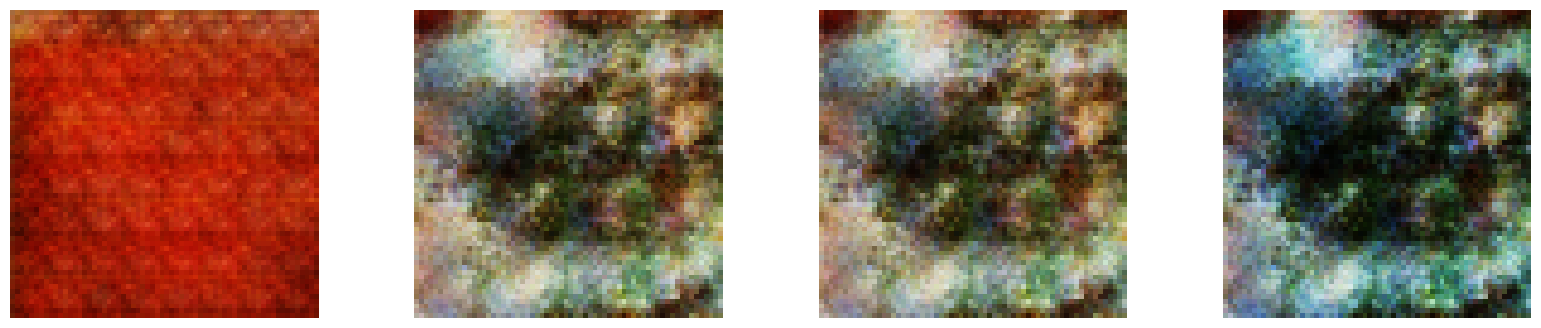

1/1 [==============================] - 0s 22ms/step
Epoch 44 	 g_loss: 622.3313, d_loss:174.3060, d_acc: 0.0000


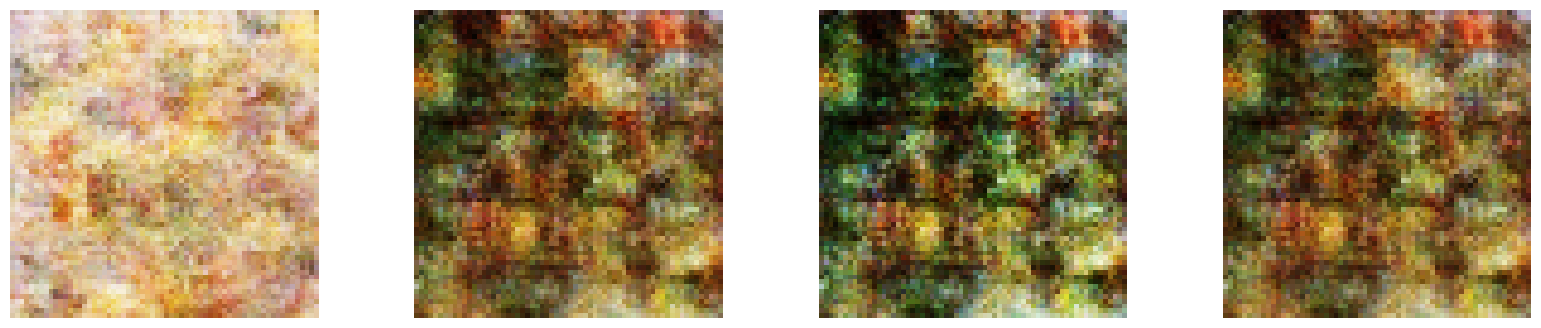

1/1 [==============================] - 0s 27ms/step
Epoch 45 	 g_loss: 600.9693, d_loss:166.7014, d_acc: 0.0000


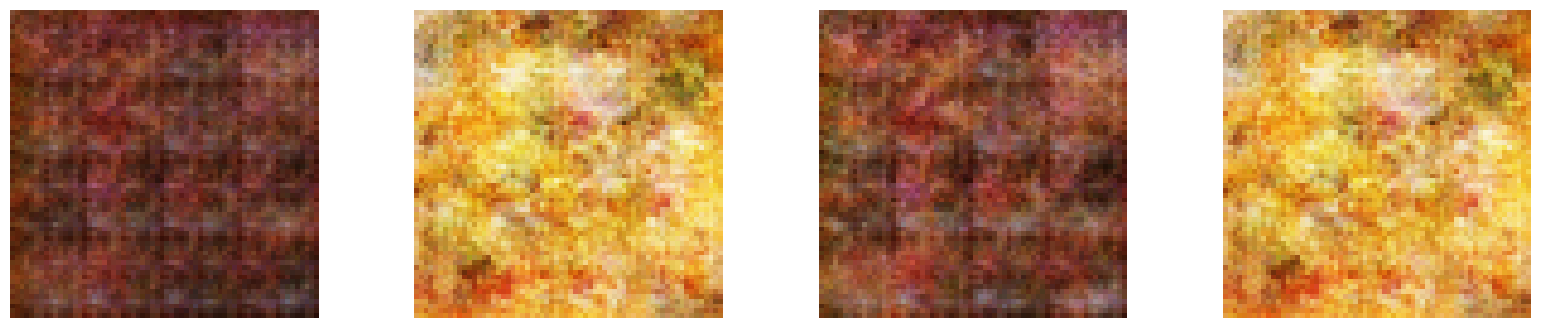

1/1 [==============================] - 0s 22ms/step
Epoch 46 	 g_loss: 587.0194, d_loss:196.5328, d_acc: 0.0000


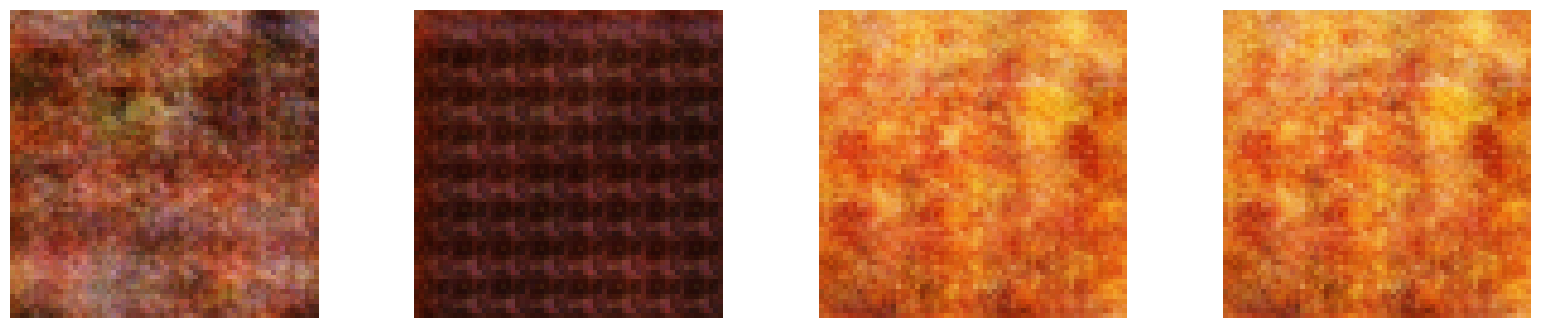

1/1 [==============================] - 0s 17ms/step
Epoch 47 	 g_loss: 558.7846, d_loss:176.2062, d_acc: 0.0000


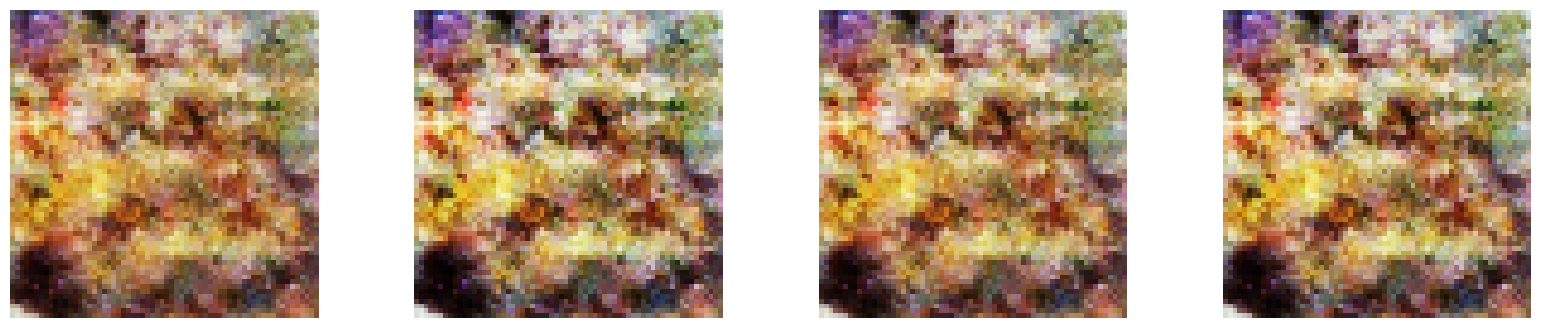

1/1 [==============================] - 0s 29ms/step
Epoch 48 	 g_loss: 577.1374, d_loss:182.6714, d_acc: 0.0000


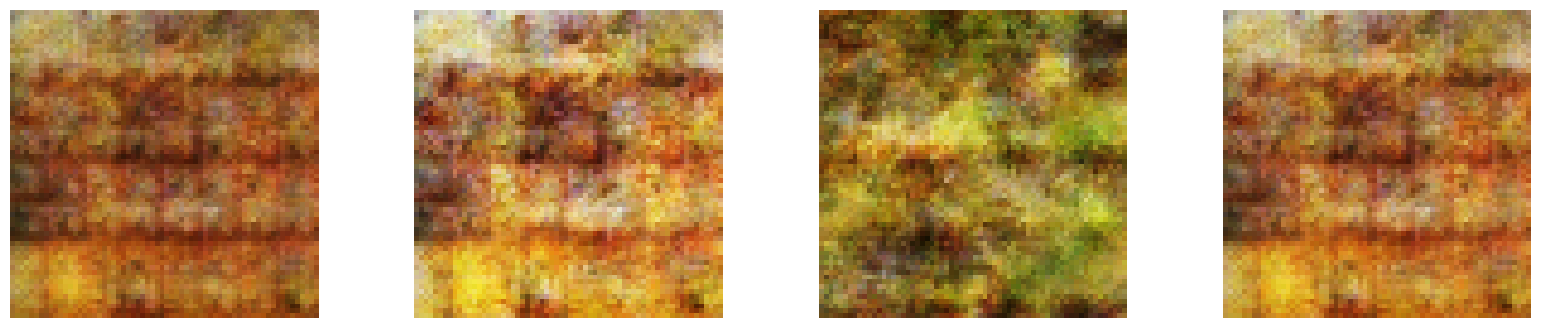

1/1 [==============================] - 0s 33ms/step
Epoch 49 	 g_loss: 619.1946, d_loss:174.7984, d_acc: 0.0000


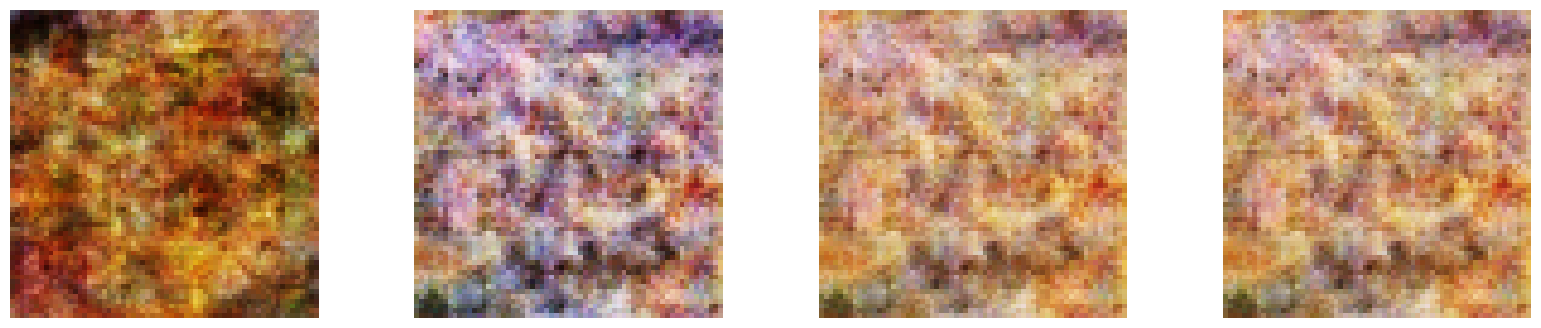

1/1 [==============================] - 0s 18ms/step
Epoch 50 	 g_loss: 610.8006, d_loss:177.6415, d_acc: 0.0000


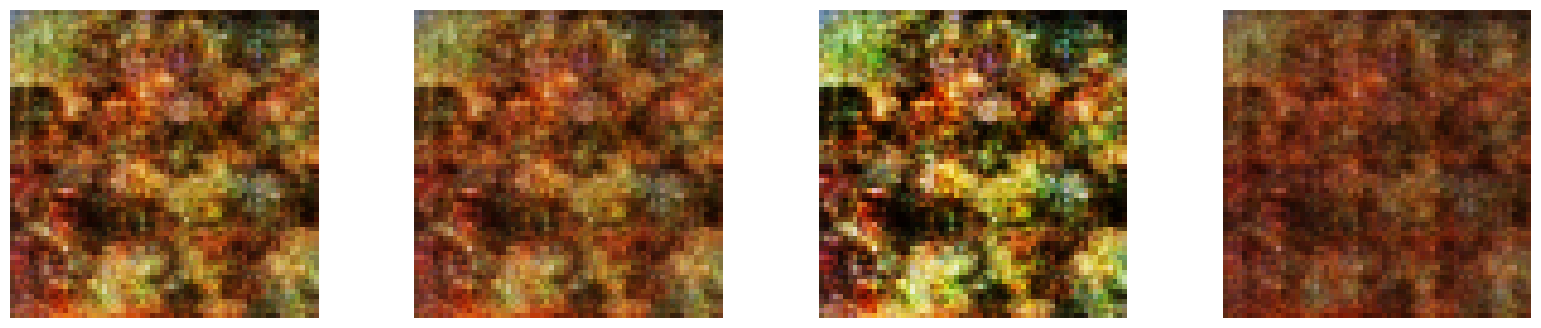

1/1 [==============================] - 0s 29ms/step
Epoch 51 	 g_loss: 610.7345, d_loss:172.9958, d_acc: 0.0000


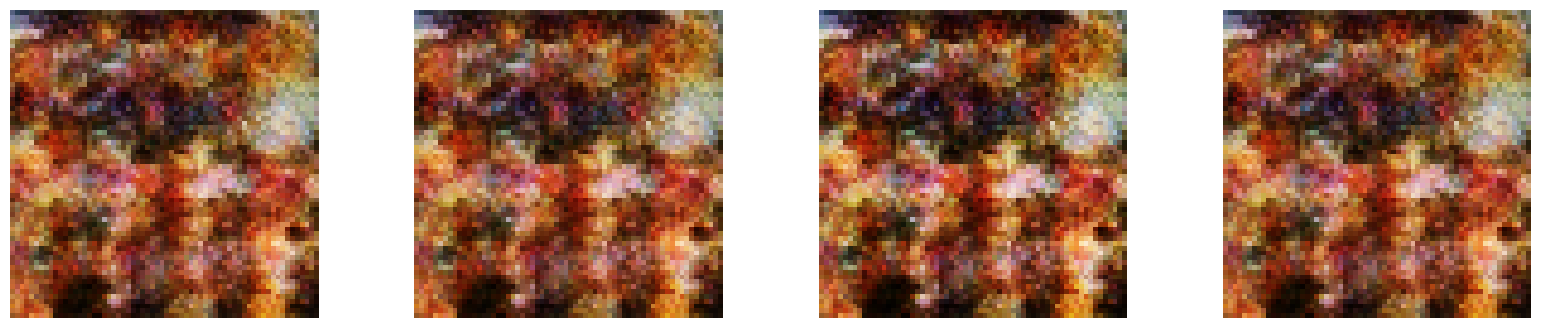

1/1 [==============================] - 0s 19ms/step
Epoch 52 	 g_loss: 591.9000, d_loss:201.2499, d_acc: 0.0000


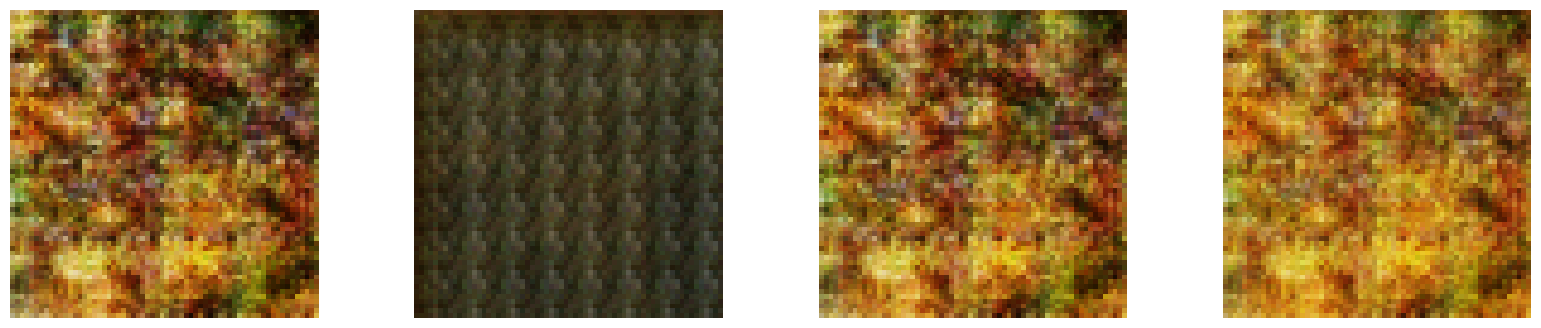

1/1 [==============================] - 0s 34ms/step
Epoch 53 	 g_loss: 429.2537, d_loss:170.2613, d_acc: 0.0000


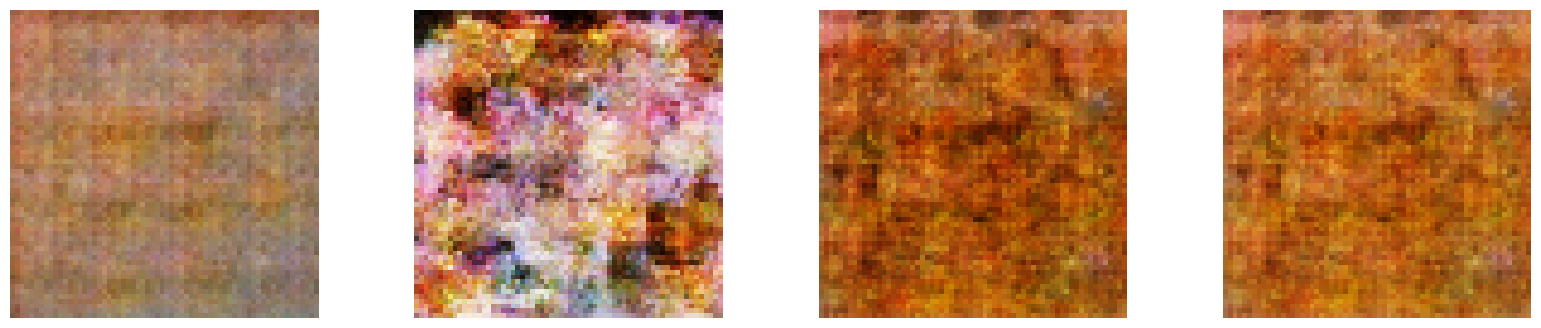

1/1 [==============================] - 0s 21ms/step
Epoch 54 	 g_loss: 411.5078, d_loss:182.2584, d_acc: 0.0000


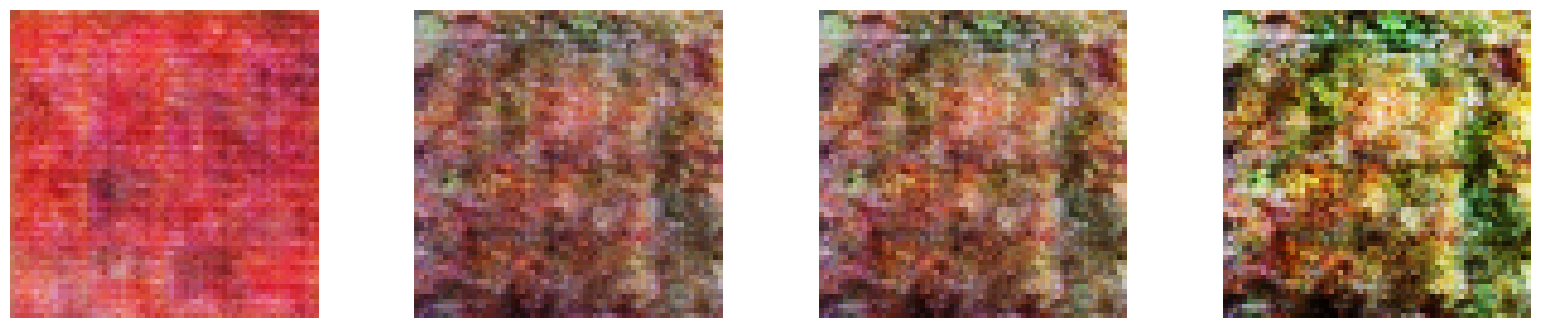

1/1 [==============================] - 0s 18ms/step
Epoch 55 	 g_loss: 605.4221, d_loss:181.6454, d_acc: 0.0000


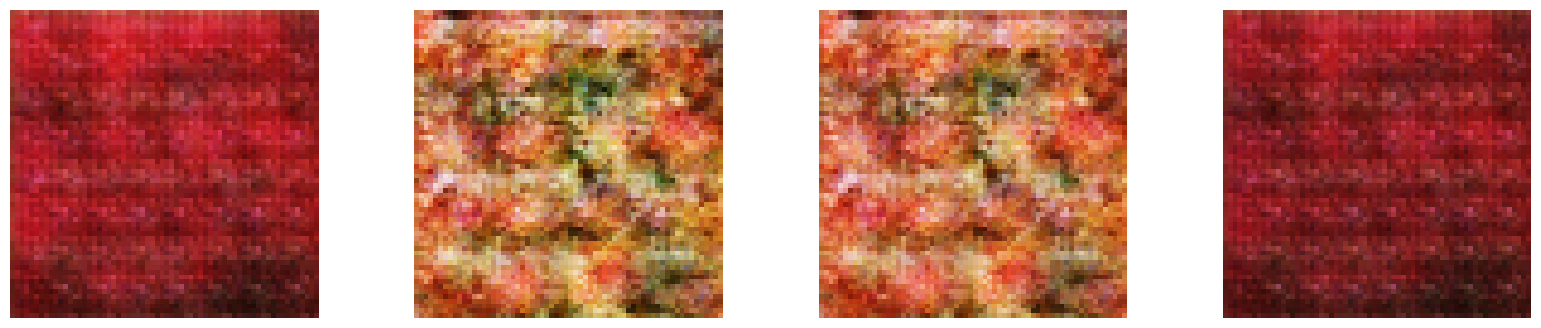

1/1 [==============================] - 0s 17ms/step
Epoch 56 	 g_loss: 613.0903, d_loss:176.0491, d_acc: 0.0000


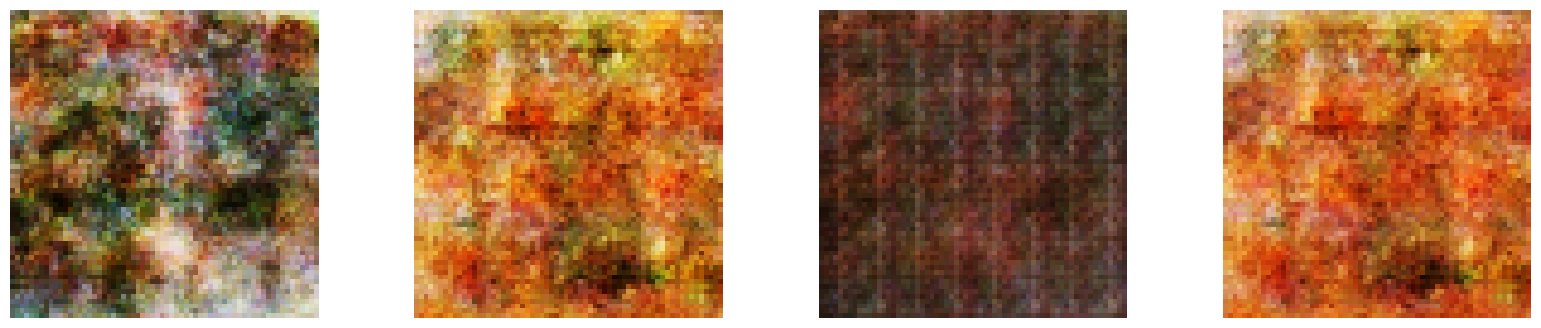

1/1 [==============================] - 0s 20ms/step
Epoch 57 	 g_loss: 624.0418, d_loss:170.8359, d_acc: 0.0000


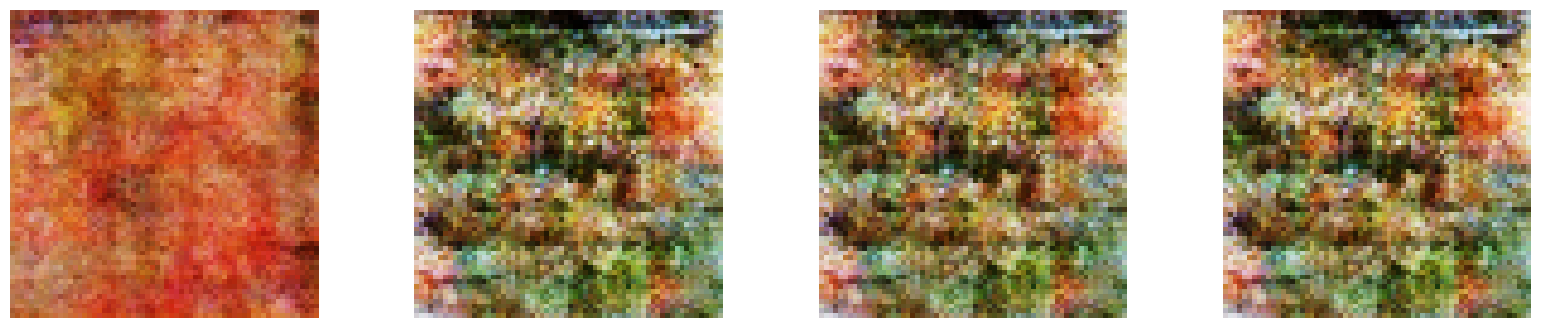

1/1 [==============================] - 0s 20ms/step
Epoch 58 	 g_loss: 585.3247, d_loss:182.9436, d_acc: 0.0000


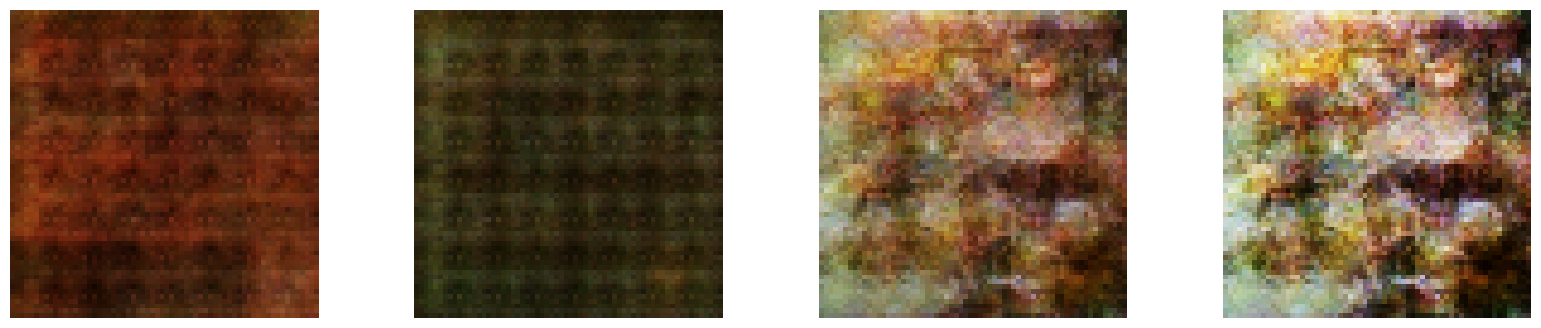

1/1 [==============================] - 0s 18ms/step
Epoch 59 	 g_loss: 612.5556, d_loss:181.9944, d_acc: 0.0000


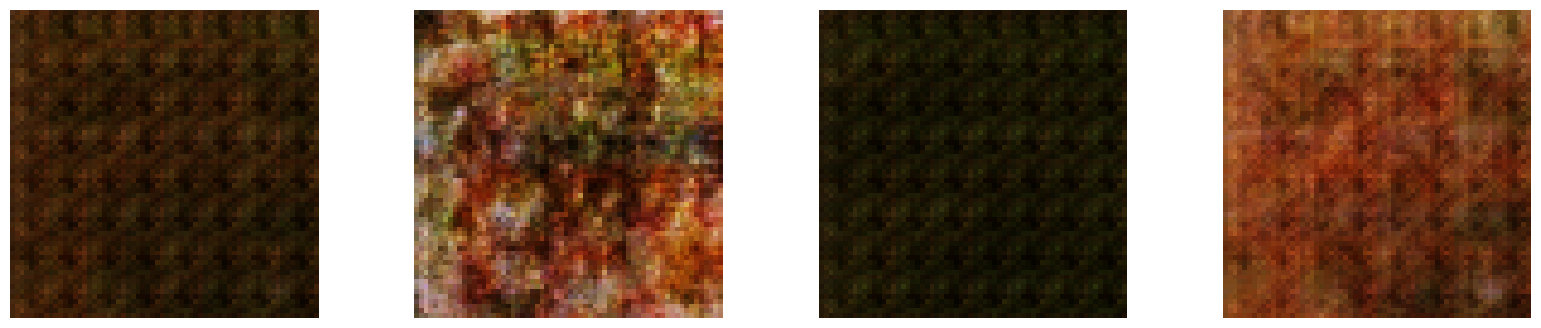

1/1 [==============================] - 0s 22ms/step
Epoch 60 	 g_loss: 644.7349, d_loss:173.1867, d_acc: 0.0000


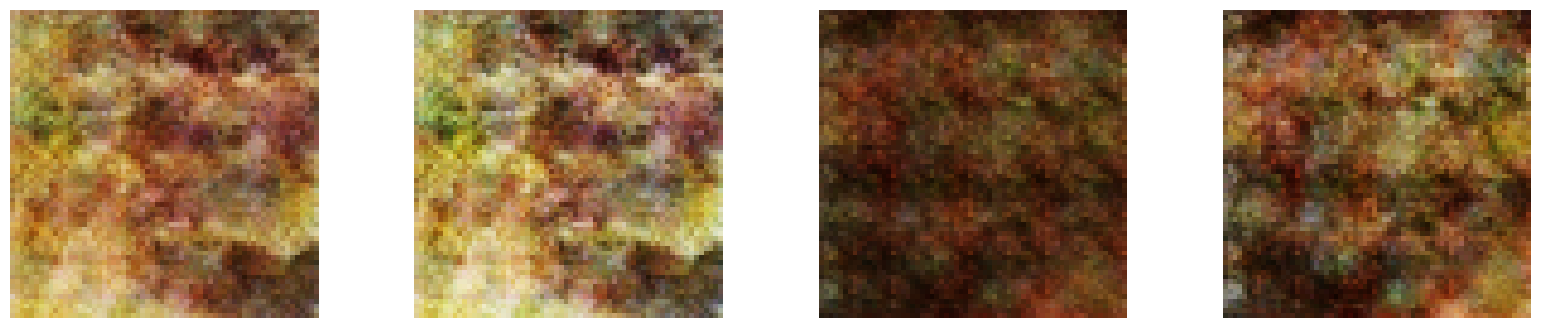

1/1 [==============================] - 0s 39ms/step
Epoch 61 	 g_loss: 616.5537, d_loss:180.1574, d_acc: 0.0000


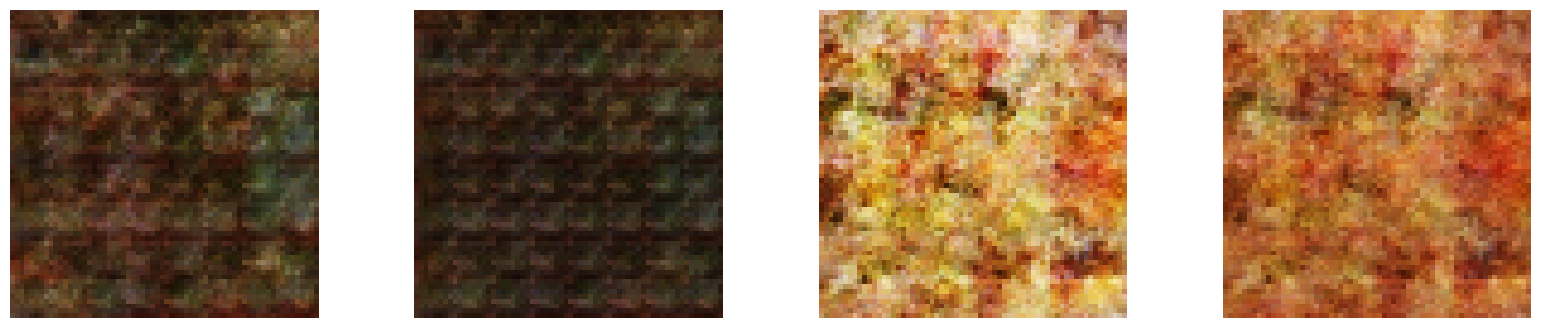

1/1 [==============================] - 0s 18ms/step
Epoch 62 	 g_loss: 710.2280, d_loss:201.0682, d_acc: 0.0000


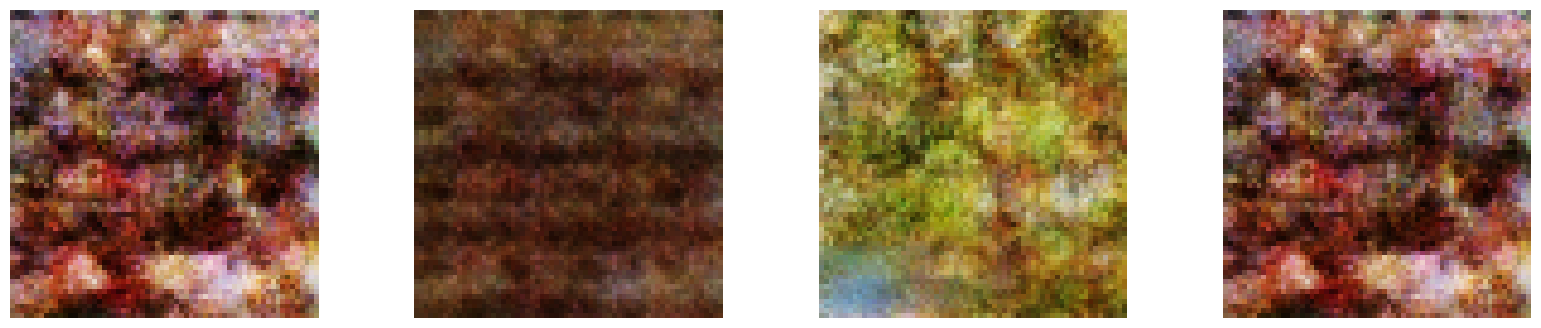

1/1 [==============================] - 0s 20ms/step
Epoch 63 	 g_loss: 352.9667, d_loss:176.8397, d_acc: 0.0000


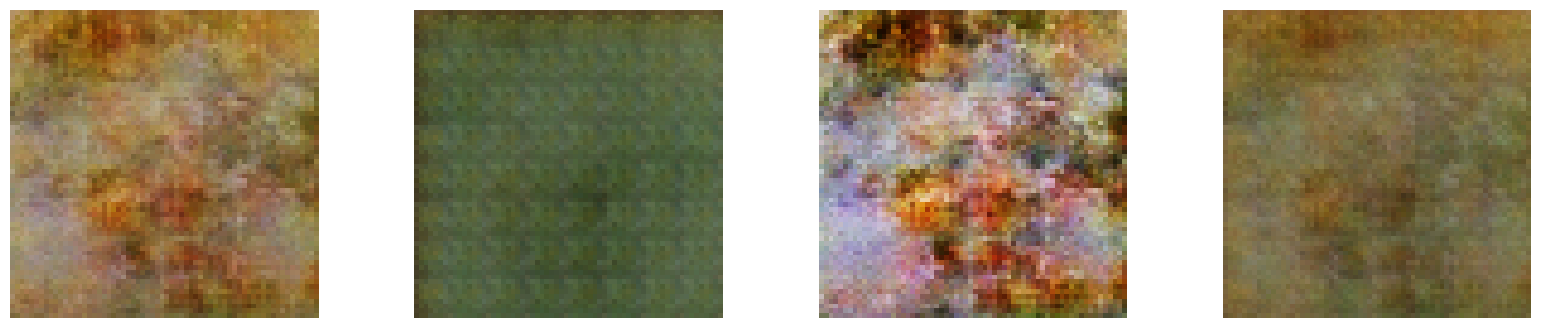

1/1 [==============================] - 0s 19ms/step
Epoch 64 	 g_loss: 412.0199, d_loss:173.9505, d_acc: 0.0000


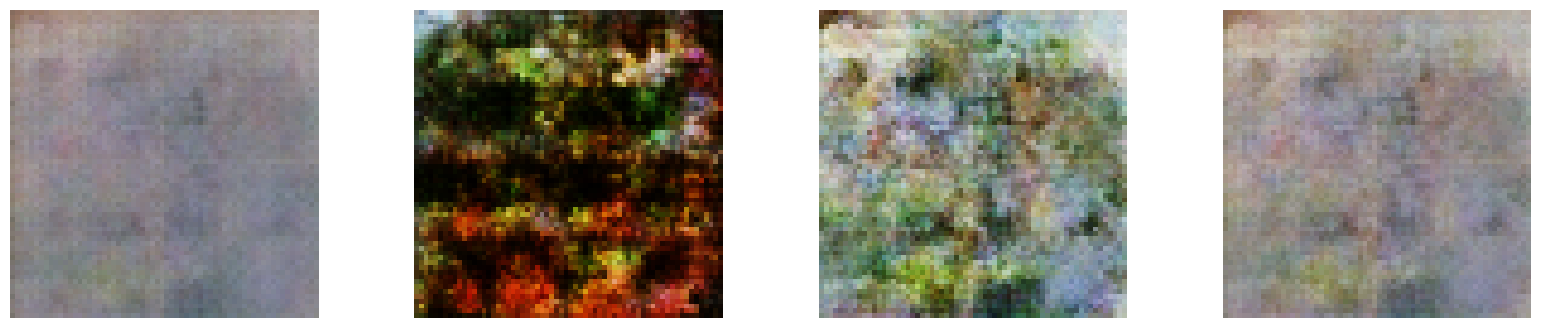

1/1 [==============================] - 0s 19ms/step
Epoch 65 	 g_loss: 268.0969, d_loss:170.1783, d_acc: 0.0000


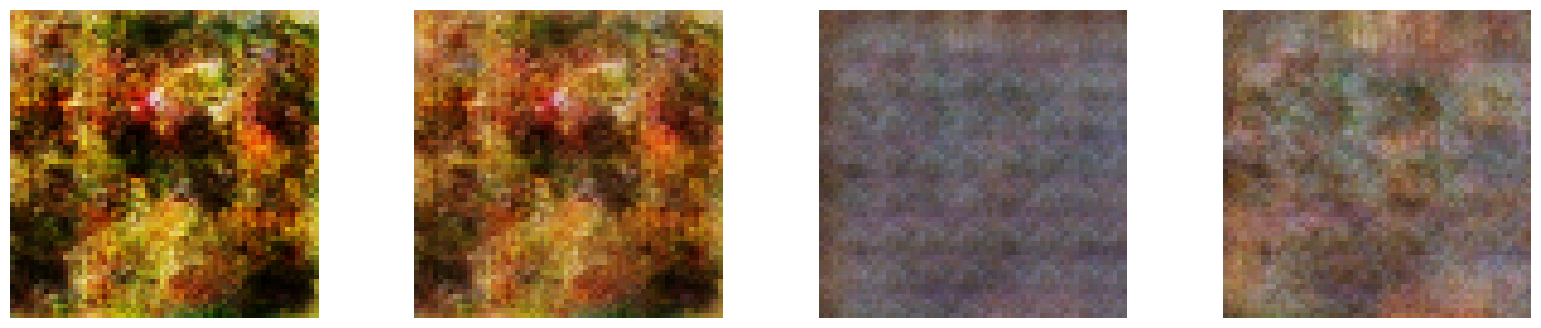

1/1 [==============================] - 0s 21ms/step
Epoch 66 	 g_loss: 446.5057, d_loss:176.4944, d_acc: 0.0000


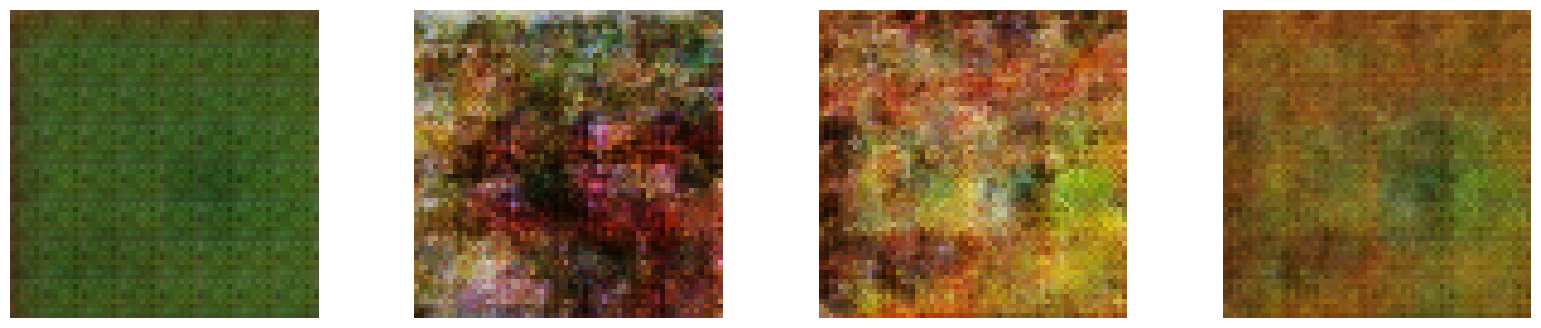

1/1 [==============================] - 0s 43ms/step
Epoch 67 	 g_loss: 404.6804, d_loss:174.7850, d_acc: 0.0000


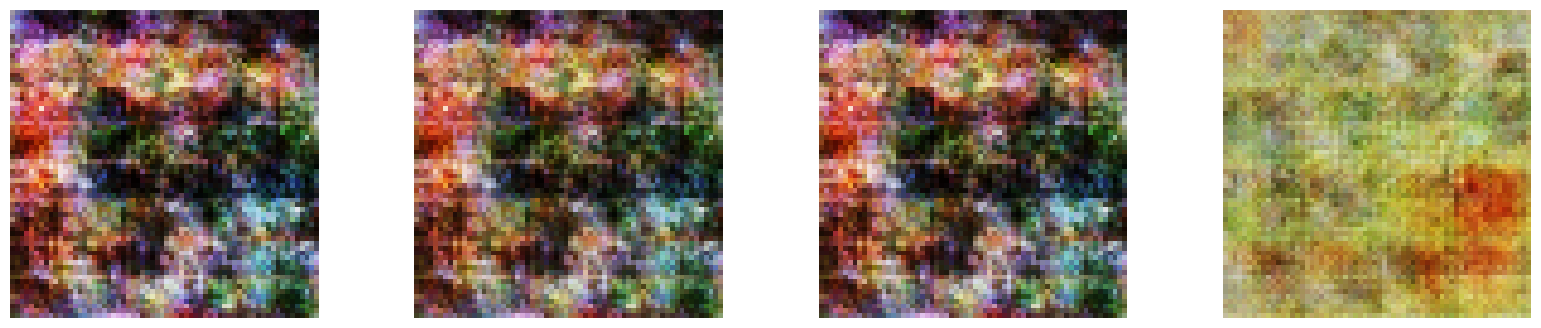

1/1 [==============================] - 0s 44ms/step
Epoch 68 	 g_loss: 396.4825, d_loss:166.8500, d_acc: 0.0000


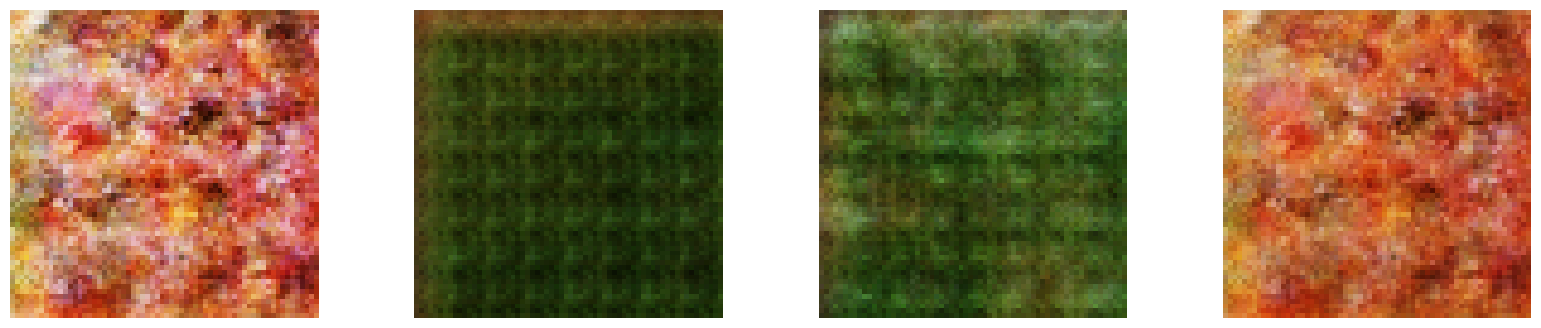

1/1 [==============================] - 0s 22ms/step
Epoch 69 	 g_loss: 536.8966, d_loss:177.5248, d_acc: 0.0000


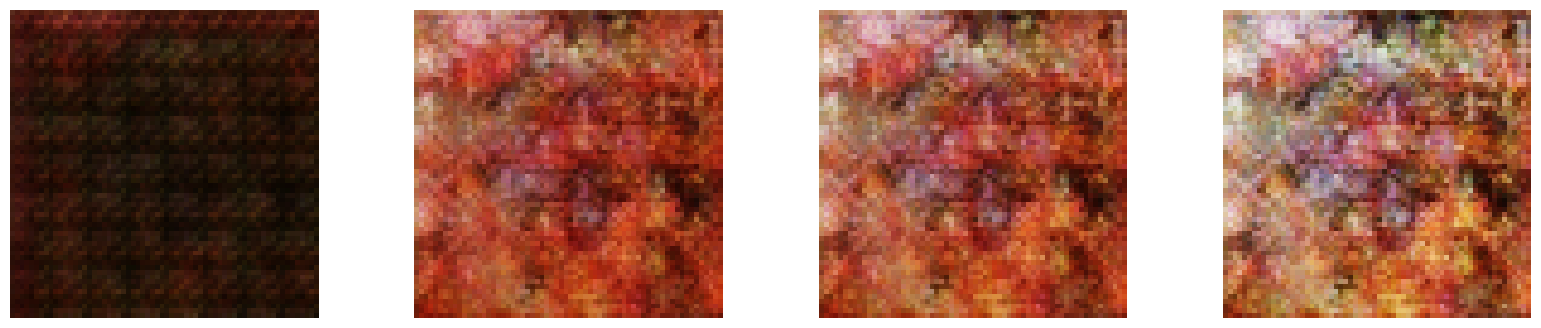

1/1 [==============================] - 0s 24ms/step
Epoch 70 	 g_loss: 635.7543, d_loss:199.9597, d_acc: 0.0000


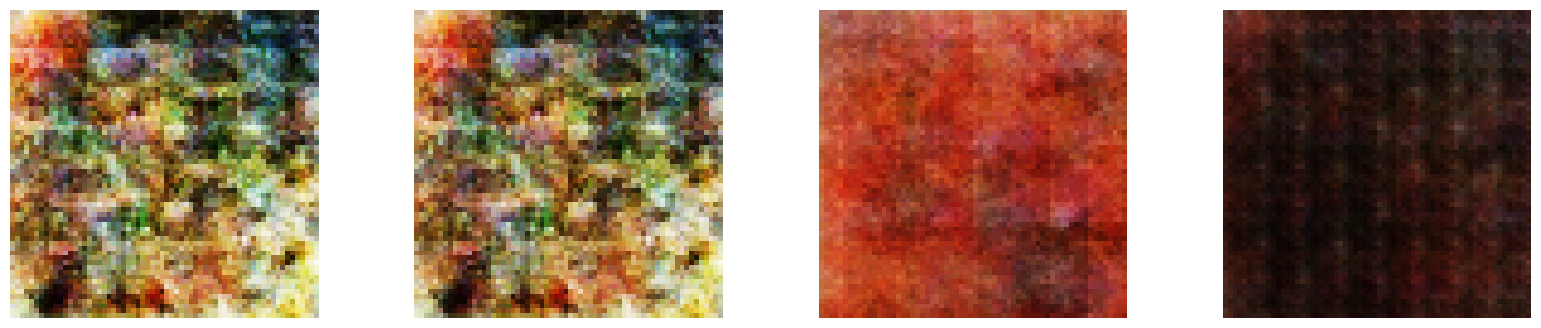

1/1 [==============================] - 0s 18ms/step
Epoch 71 	 g_loss: 572.3631, d_loss:177.8027, d_acc: 0.0000


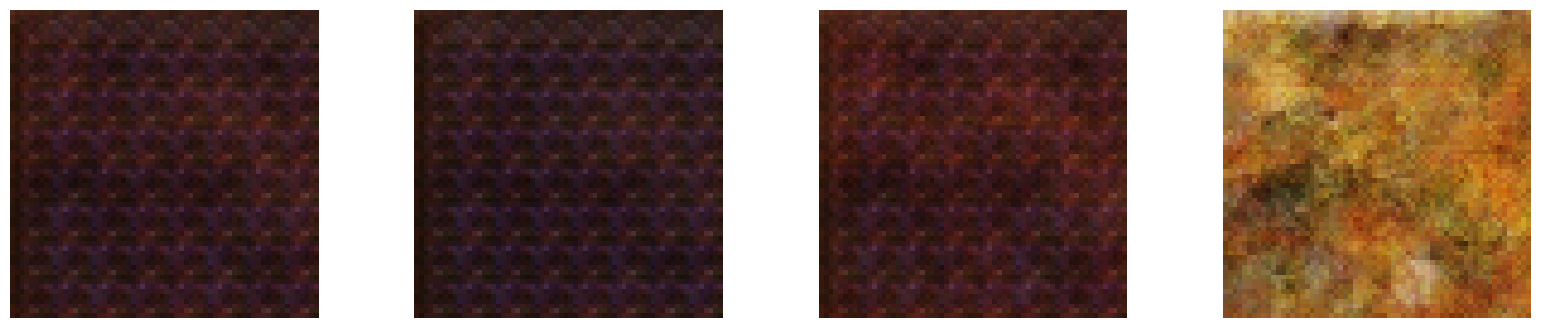

1/1 [==============================] - 0s 17ms/step
Epoch 72 	 g_loss: 603.6402, d_loss:184.7824, d_acc: 0.0000


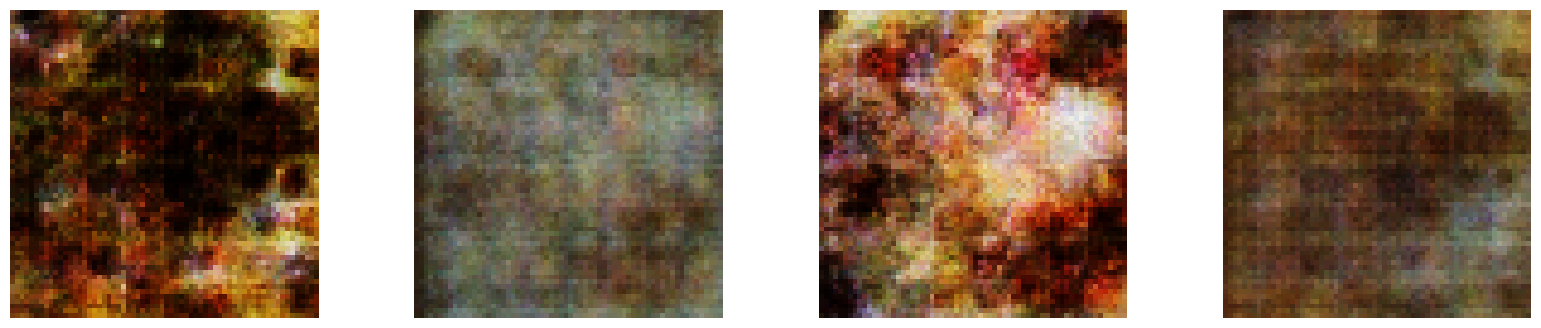

1/1 [==============================] - 0s 20ms/step
Epoch 73 	 g_loss: 394.5348, d_loss:179.2045, d_acc: 0.0000


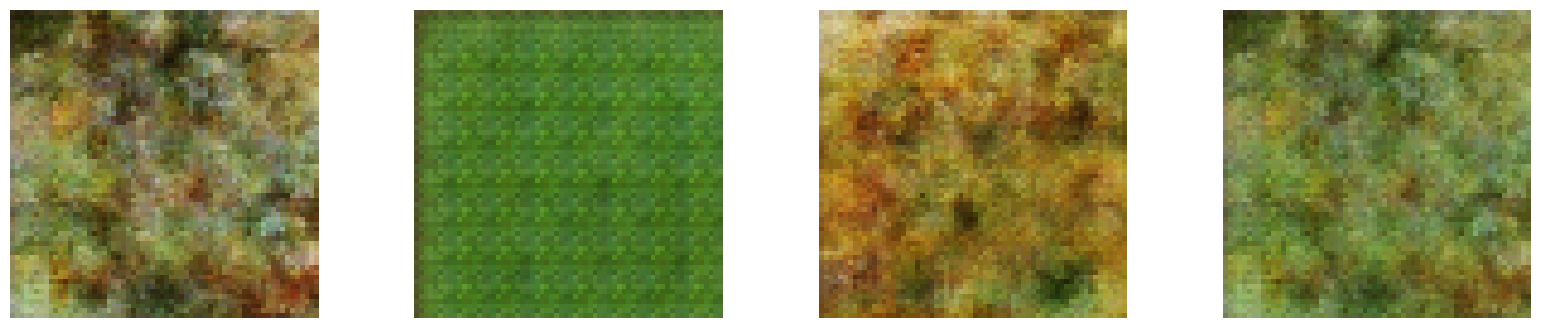

1/1 [==============================] - 0s 18ms/step
Epoch 74 	 g_loss: 493.9579, d_loss:170.2803, d_acc: 0.0000


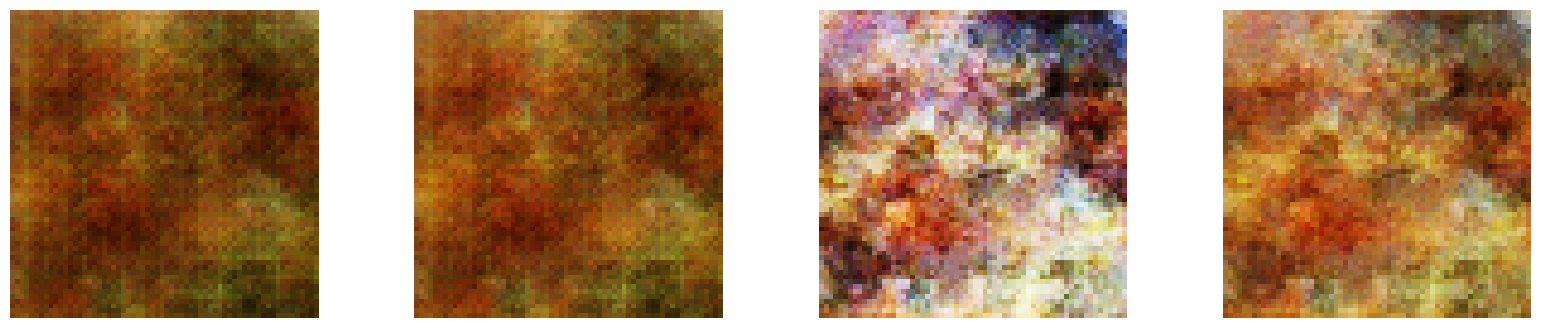

1/1 [==============================] - 0s 17ms/step
Epoch 75 	 g_loss: 540.2746, d_loss:181.8153, d_acc: 0.0000


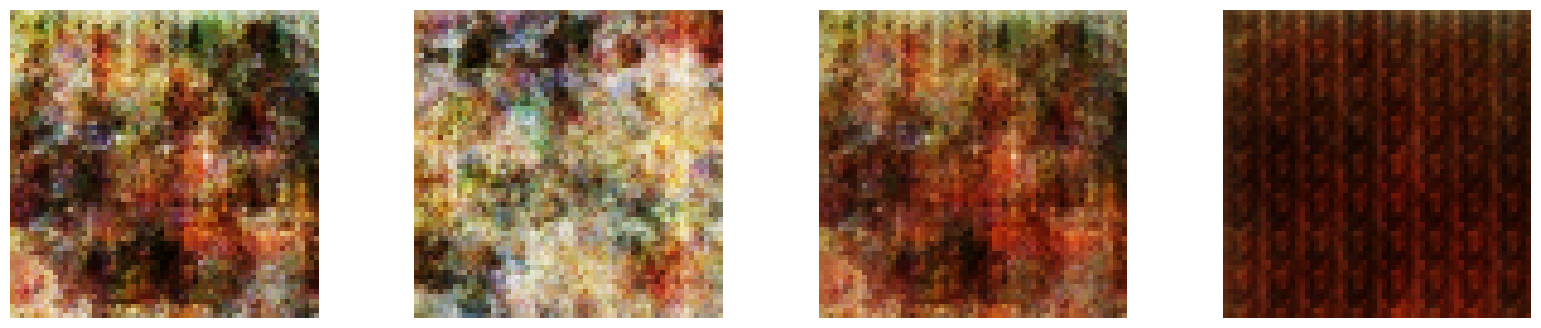

1/1 [==============================] - 0s 20ms/step
Epoch 76 	 g_loss: 614.6681, d_loss:169.3030, d_acc: 0.0000


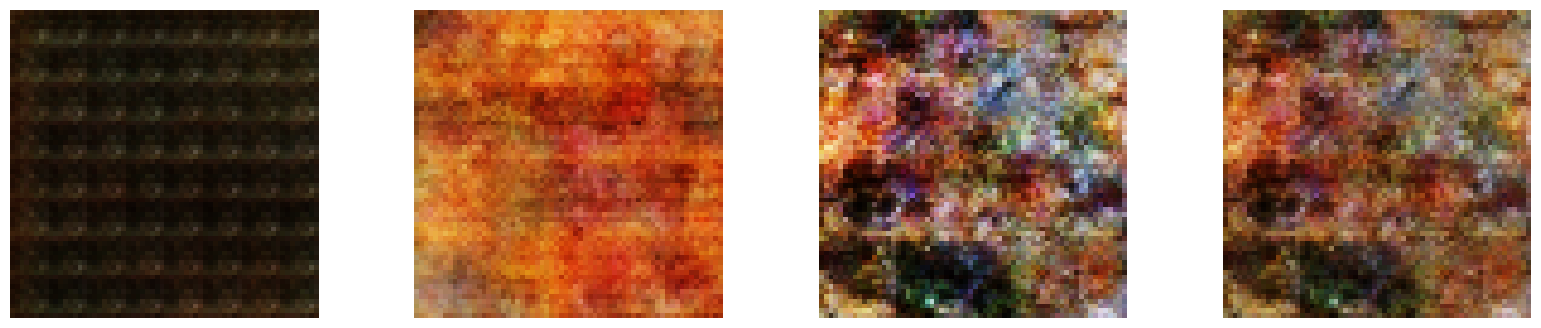

1/1 [==============================] - 0s 20ms/step


In [ ]:
import time
import matplotlib.pyplot as plt

## Hyperparameters
hidden_dim = 1
epochs = 200
batch_size = 32
display_epochs = 1

# build the generator
generator = build_generator_DC(hidden_dim)
generator.summary()

# build the discriminator and compile
discriminator = build_discriminator_DC()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()

# build the combined model
DCGAN = build_DCGAN(hidden_dim, generator, discriminator)
DCGAN.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5, beta_1=0.5))
DCGAN.summary()

# batch info (m = 10099)
n_batch = m // batch_size
n_remain = m % batch_size


def train_DCGAN(epochs, batch_size, display_epochs):
    # losses for each epoch
    d_loss_history = []
    g_loss_history = []

    for epoch in range(epochs + 1):
        d_loss = 0
        g_loss = 0
        d_acc = 0

        for batch_i in range(n_batch + 1):
            # sample size
            if batch_i != n_batch:
                sample_size = batch_size
            else:
                sample_size = n_remain

            # take a batch of real images
            if batch_i != n_batch:
                real_images = data[batch_i * batch_size: (batch_i + 1) * batch_size]
                assert real_images.shape[0] == batch_size
                real_labels = smoothing_true_labels(np.ones(batch_size))
            else:  # last batch
                real_images = data[-n_remain:]
                assert real_images.shape[0] == n_remain
                real_labels = smoothing_true_labels(np.ones(n_remain))

            # create a batch of fake images
            z = np.random.uniform(low=0.0, high=1.0, size=(sample_size, hidden_dim))
            fake_images = generator.predict(z)
            fake_labels = smoothing_fake_labels(np.zeros(sample_size))

            # train discriminator
            d_real_loss, d_real_acc = discriminator.train_on_batch(real_images, real_labels)
            d_fake_loss, d_fake_acc = discriminator.train_on_batch(fake_images, fake_labels)

            d_loss += (d_real_loss + d_fake_loss)
            d_acc += (d_real_acc + d_fake_acc) * sample_size

            # train generator
            z = np.random.uniform(low=0.0, high=1.0, size=(sample_size, hidden_dim))
            g_loss += DCGAN.train_on_batch(z, np.ones(sample_size))

        d_acc /= (2 * m)

        # log losses
        g_loss_history.append(g_loss)
        d_loss_history.append(d_loss)

        if epoch % display_epochs == 0:
            # print info
            print("Epoch {} \t g_loss: {:.4f}, d_loss:{:.4f}, d_acc: {:.4f}".format(
                epoch, g_loss, d_loss, d_acc))

            # plot fake images
            plt.figure(figsize=(20, 4))
            for i in range(4):  # Adjusted to display 4 images per epoch
                fake_img = fake_images.copy()[i].reshape(64, 64, 3)
                fake_img = (127.5 * (fake_img + 1)).astype(int)
                plt.subplot(1, 4, i + 1)  # Adjusted subplot to display 4 images
                plt.axis('off')
                plt.imshow(fake_img)
            plt.show()

    return g_loss_history, d_loss_history


# Train
g_loss_history, d_loss_history = train_DCGAN(epochs, batch_size, display_epochs)

# Plot loss during training
plt.figure()
plt.plot(g_loss_history, 'b')
plt.plot(d_loss_history, 'r')
plt.show()
